In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

# # Remote Data Access
# import pandas_datareader.data as web
# import datetime
# # reference: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

/Users/MAC/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def ar1(phi = .9, n = 1000, init = 0):
    time_series = [init]
    error = np.random.randn(n)
    for period in range(n):
        time_series.append(error[period] + phi*time_series[-1])
    return pd.Series(time_series[1:], index = range(n))
    
def ar2(phi1 = .9, phi2 = -.8, n = 1000, init = 0):
    time_series = [init, init]
    error = np.random.randn(n)
    for period in range(2,n):
        time_series.append(error[period] + phi1*time_series[-1] + phi2*time_series[-2])
    return pd.Series(time_series[1:], index = range(1,n))

def ma1(theta = .5, n = 100):
    time_series = []
    error = np.random.randn(n)
    for period in range(1,n):
        time_series.append(error[period] + theta*error[period-1])
    return pd.Series(time_series[1:], index = range(1,n-1))

In [3]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
       Original source: https://tomaugspurger.github.io/modern-7-timeseries.html'''
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [4]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

# 1. What is the difference between Linear Regression and Time Series Analysis?

In [5]:
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])

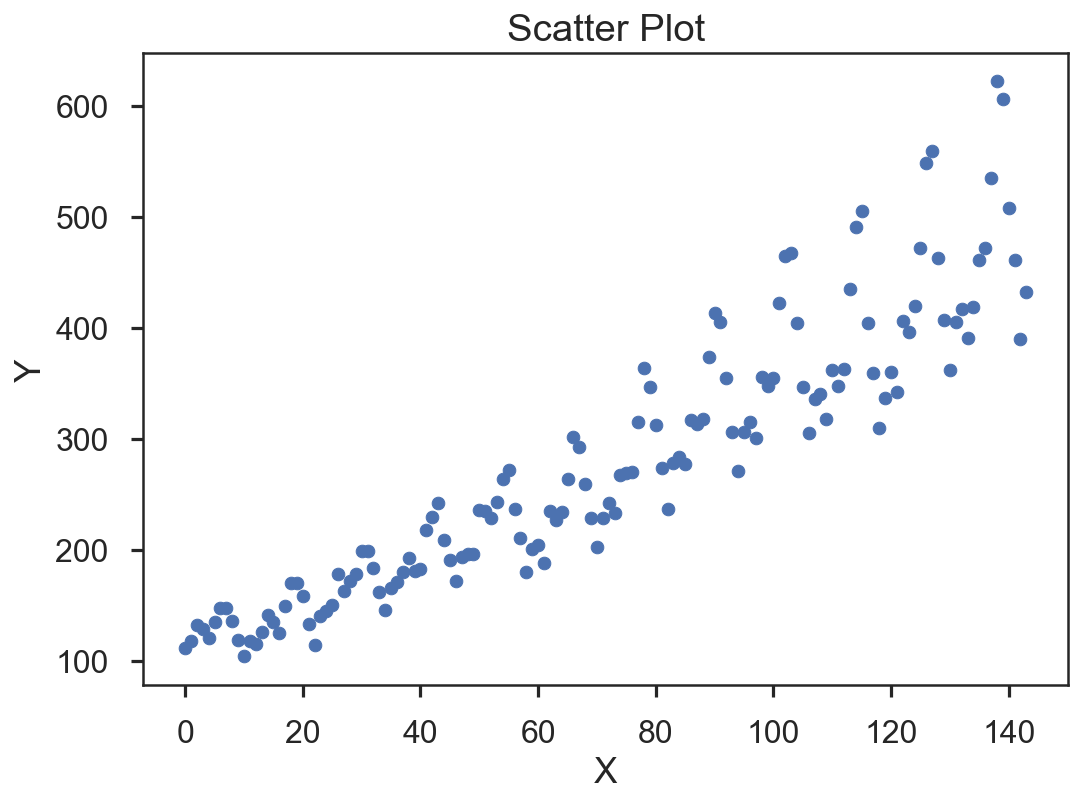

In [6]:
# plt.scatter(list(range(0, len(air.n_pass_thousands))), air.n_pass_thousands)
x = np.array(range(0, len(air.n_pass_thousands)))
y = air.n_pass_thousands.values
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, s=40)
ax.set_title('Scatter Plot');
ax.set_ylabel('Y');
ax.set_xlabel('X');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

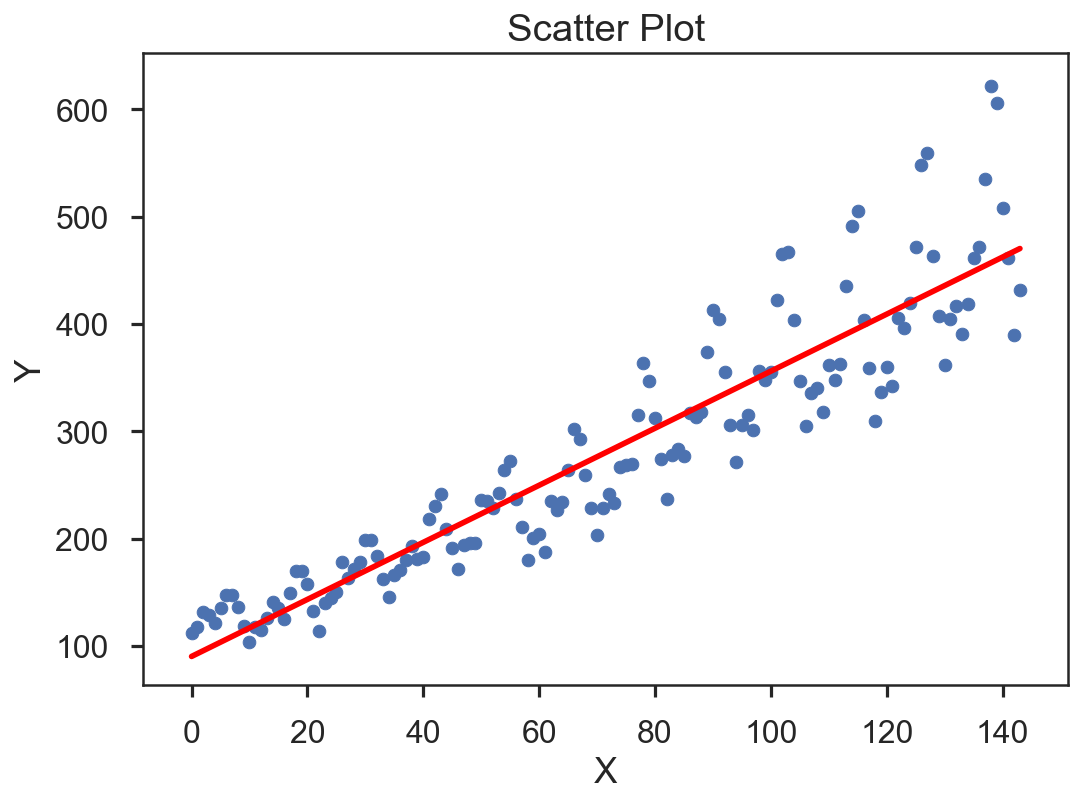

In [7]:
# plt.scatter(list(range(0, len(air.n_pass_thousands))), air.n_pass_thousands)
x = np.array(range(0, len(air.n_pass_thousands)))
y = air.n_pass_thousands.values
fig, ax = plt.subplots(figsize=(8,6))
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=40)
ax.set_title('Scatter Plot');
ax.set_ylabel('Y');
ax.set_xlabel('X');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

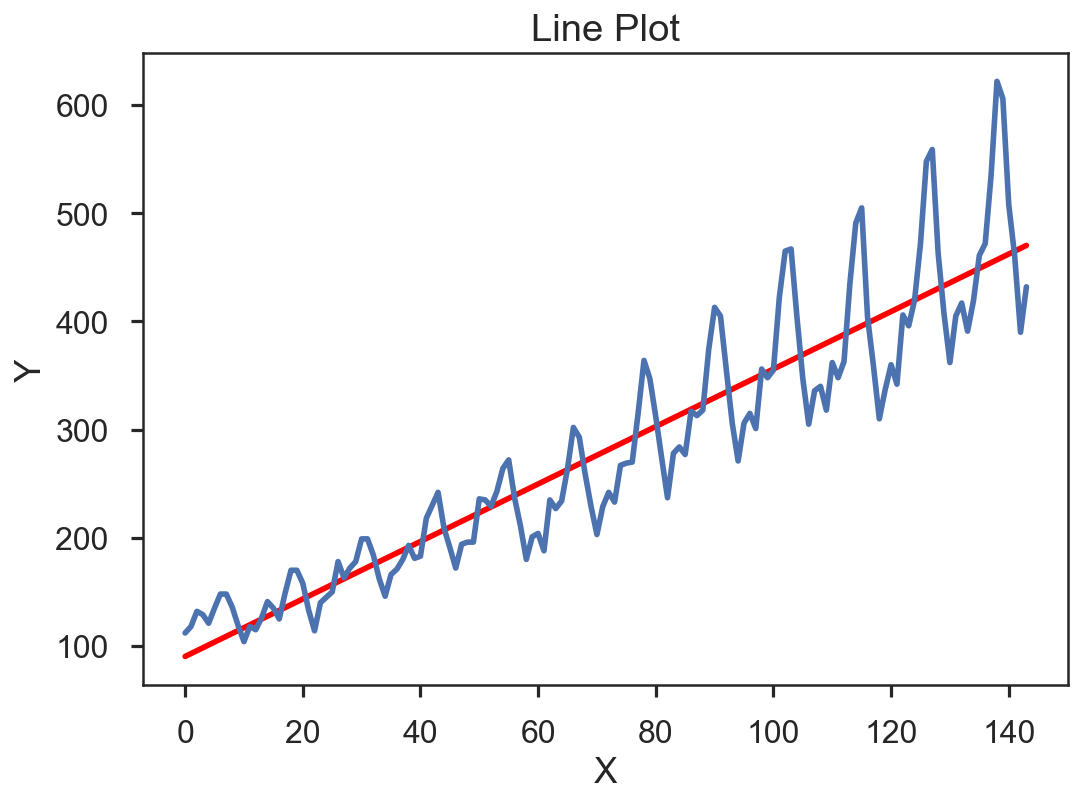

In [8]:
# plt.scatter(list(range(0, len(air.n_pass_thousands))), air.n_pass_thousands)
x = np.array(range(0, len(air.n_pass_thousands)))
y = air.n_pass_thousands.values
fig, ax = plt.subplots(figsize=(8,6))
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.plot(x, y)
ax.set_title('Line Plot');
ax.set_ylabel('Y');
ax.set_xlabel('X');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

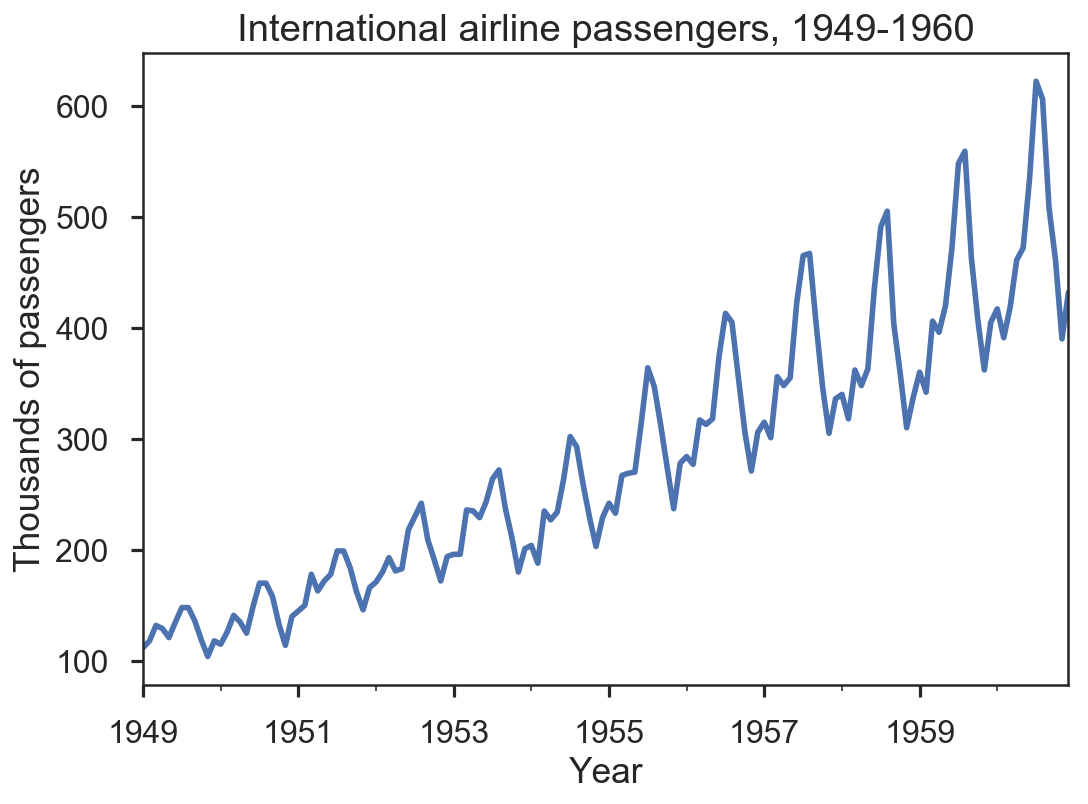

In [9]:
fig, ax = plt.subplots(figsize=(8,6));
air['n_pass_thousands'].plot(ax=ax);
ax.set_title('International airline passengers, 1949-1960');
ax.set_ylabel('Thousands of passengers');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

# 2. Let's take a look at some characteristics of Time Series data.
### 2.1 Stationarity
### 2.2 Autocorrelation Funcaiton (ACF), Partial Autocorrelation Function (PACF)
### 2.3 Seasonality
### 2.4 White Noise
### 2.5 Random Walk

### 2.1 Stationarity
* A weaker and more practical stationarity condition is that of $\textit{weakly stationary}$ (or $\textit{second order stationarity}$). A time series $x_t$ is said to be $\textit{weakly stationary}$ if its mean and variance stationary and its autocovariance $Cov(x_t,x_{t-k})$ depends only the time displacement $k$ and can be written as $\gamma(k)$. 

### Augmented Dickey–Fuller test (ADF): test for stationarity
* $\Delta x_t = \alpha + \gamma x_{t-1} + \beta_1 \Delta x_{t-1} + \beta_2 \Delta x_{t-2} + ... + \beta_p \Delta x_{t-p+1} + \omega_{1,t} $
* $H_0: \gamma = 0$, there is a unit root. (the series is non-stationary)
* $H_1: \gamma < 0$, there is not a unit root. (the series is stationary)


In [10]:
import statsmodels.tsa.stattools as ts
adf_data = np.array(air.n_pass_thousands)
result = ts.adfuller(adf_data, 1) 
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = result[0]
output['value']['p-value'] = result[1]
output['value']['Lags Used'] = result[2]
output['value']['Number of Observations Used'] = result[3]
output['value']['Critical Value(1%)'] = result[4]['1%']
output['value']['Critical Value(5%)'] = result[4]['5%']
output['value']['Critical Value(10%)'] = result[4]['10%']
output

value
Test Statistic Value        -2.34503
p-value                      0.15786
Lags Used                          1
Number of Observations Used      142
Critical Value(1%)          -3.47726
Critical Value(5%)          -2.88212
Critical Value(10%)         -2.57774

In [11]:
# Take log of the series
air['lnair'] = np.log(air)
print(air['lnair'].head(),"\n")
print(air['lnair'].shape,"\n")

# Take first difference of the series
#air_ln_diff = air['lnair'].diff() - air['lnair'].shift()
air_ln_diff = air['lnair'].diff()
air_ln_diff = air_ln_diff.dropna()
print(air_ln_diff.head(),"\n")
print(air_ln_diff.shape,"\n")

Month
1949-01-01   4.71850
1949-02-01   4.77068
1949-03-01   4.88280
1949-04-01   4.85981
1949-05-01   4.79579
Name: lnair, dtype: float64 

(144,) 

Month
1949-02-01    0.05219
1949-03-01    0.11212
1949-04-01   -0.02299
1949-05-01   -0.06402
1949-06-01    0.10948
Name: lnair, dtype: float64 

(143,) 



In [12]:
adf_data = np.array(air.n_pass_thousands)
result = ts.adfuller(air_ln_diff, 1) 
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = result[0]
output['value']['p-value'] = result[1]
output['value']['Lags Used'] = result[2]
output['value']['Number of Observations Used'] = result[3]
output['value']['Critical Value(1%)'] = result[4]['1%']
output['value']['Critical Value(5%)'] = result[4]['5%']
output['value']['Critical Value(10%)'] = result[4]['10%']
output

value
Test Statistic Value        -8.85951
p-value                      0.00000
Lags Used                          1
Number of Observations Used      141
Critical Value(1%)          -3.47760
Critical Value(5%)          -2.88227
Critical Value(10%)         -2.57782

### 2.2 Autocorrelation Funcaiton (ACF), Partial Autocorrelation Function (PACF)
* The $\textbf{autocovariance function}$ is defined as

$$\gamma_{x}(s,t) = cov(x_s,x_t) = E[(x_s-\mu_s)(x_t-\mu_t)] \forall s,t$$

* Two natural implications are $(1) \gamma_{x}(s,t) = \gamma_{x}(t,s)$ and $(2)$ $\gamma_{x}(s,s) = cov(x_s,x_s) = E[(x_s-\mu_s)^2]$

* A correlation of a variable with itself at different times is known as $\textit{autocorrelation}$. If a time series model is second-order stationary (i.e. stationary in both mean and variance: $\mu_t = \mu$ and $\sigma_t^2 = \sigma^2$ for all $t$), then an $\textit{autocovariance function}$ can be expressed as a function only of the time lag $k$:

$$ \gamma_k = E[(x_t-\mu)(x_{t-k} - \mu)] $$
  
* Likewise, the $\textit{autocorrelation function (ACF)}$ is defined as

$$ \rho_k = \frac{\gamma_k}{\sigma^2} $$
  
* When $k=0$, $\rho_0 = 1$

* The $\textbf{partial autocorrelation function}$ is defined as the estimation of the coefficients $\phi_{1,1}, \phi_{2,2}, \phi_{3,3}$, etc.
* Example: The estimate $\hat \phi_{1,1}$ of the first equation is called the lag-1 sample PACF of $x_t$

* $x_t = \phi_{0,1} + \phi_{1,1} x_{t-1} + \omega_{1,t} $

* $x_t = \phi_{0,2} + \phi_{1,2} x_{t-1} + \phi_{2,2} x_{t-2} + \omega_{2,t} $

* $x_t = \phi_{0,3} + \phi_{1,3} x_{t-1} + \phi_{2,3} x_{t-2} + \phi_{3,3} x_{t-3} + \omega_{3,t} $

* $x_t = \phi_{0,4} + \phi_{1,4} x_{t-1} + \phi_{2,4} x_{t-2} + \phi_{3,4} x_{t-3} + + \phi_{4,4} x_{t-4} + \omega_{4,t} $

(<matplotlib.axes._subplots.AxesSubplot at 0x1222df6d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122ba6438>)

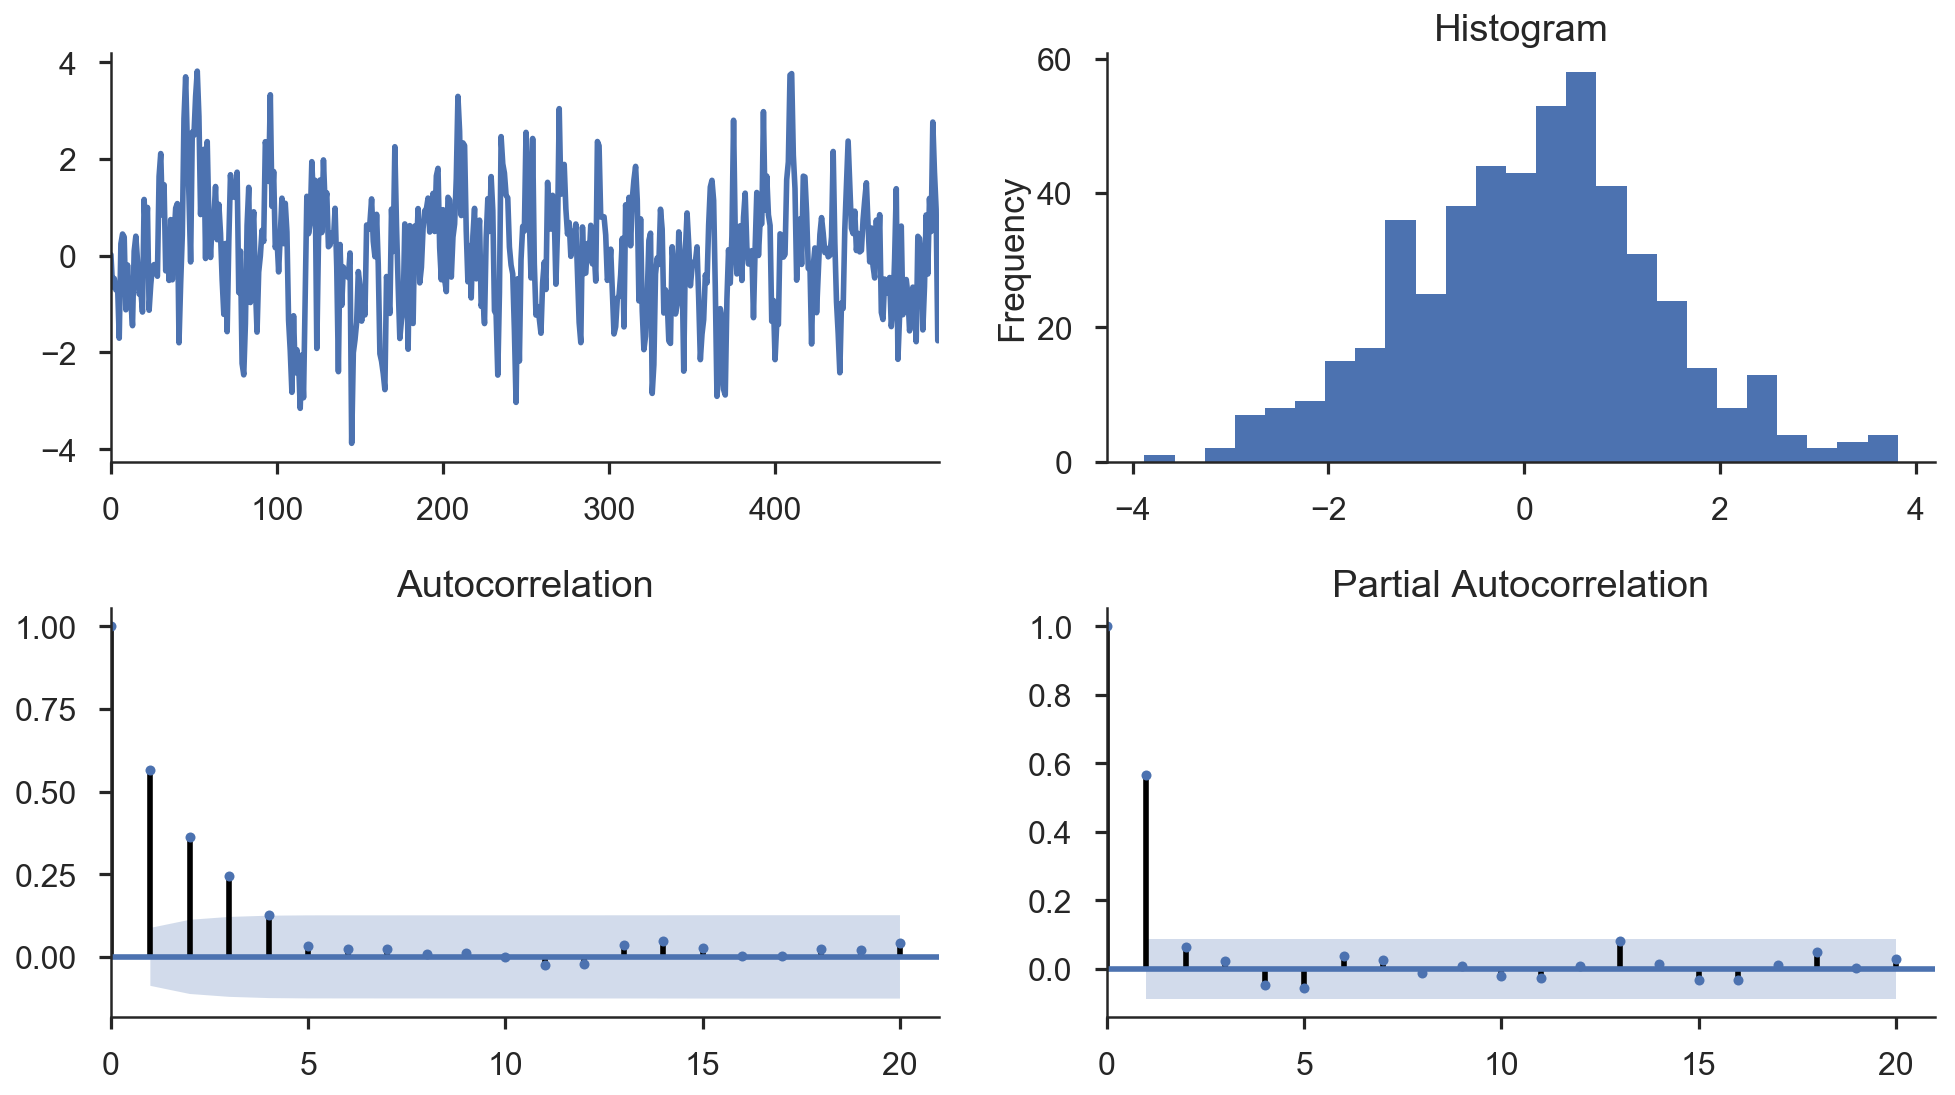

In [13]:
tsplot(ar1(phi = 0.5, n = 500), lags = 20)

(<matplotlib.axes._subplots.AxesSubplot at 0x121ed4cc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123550a58>)

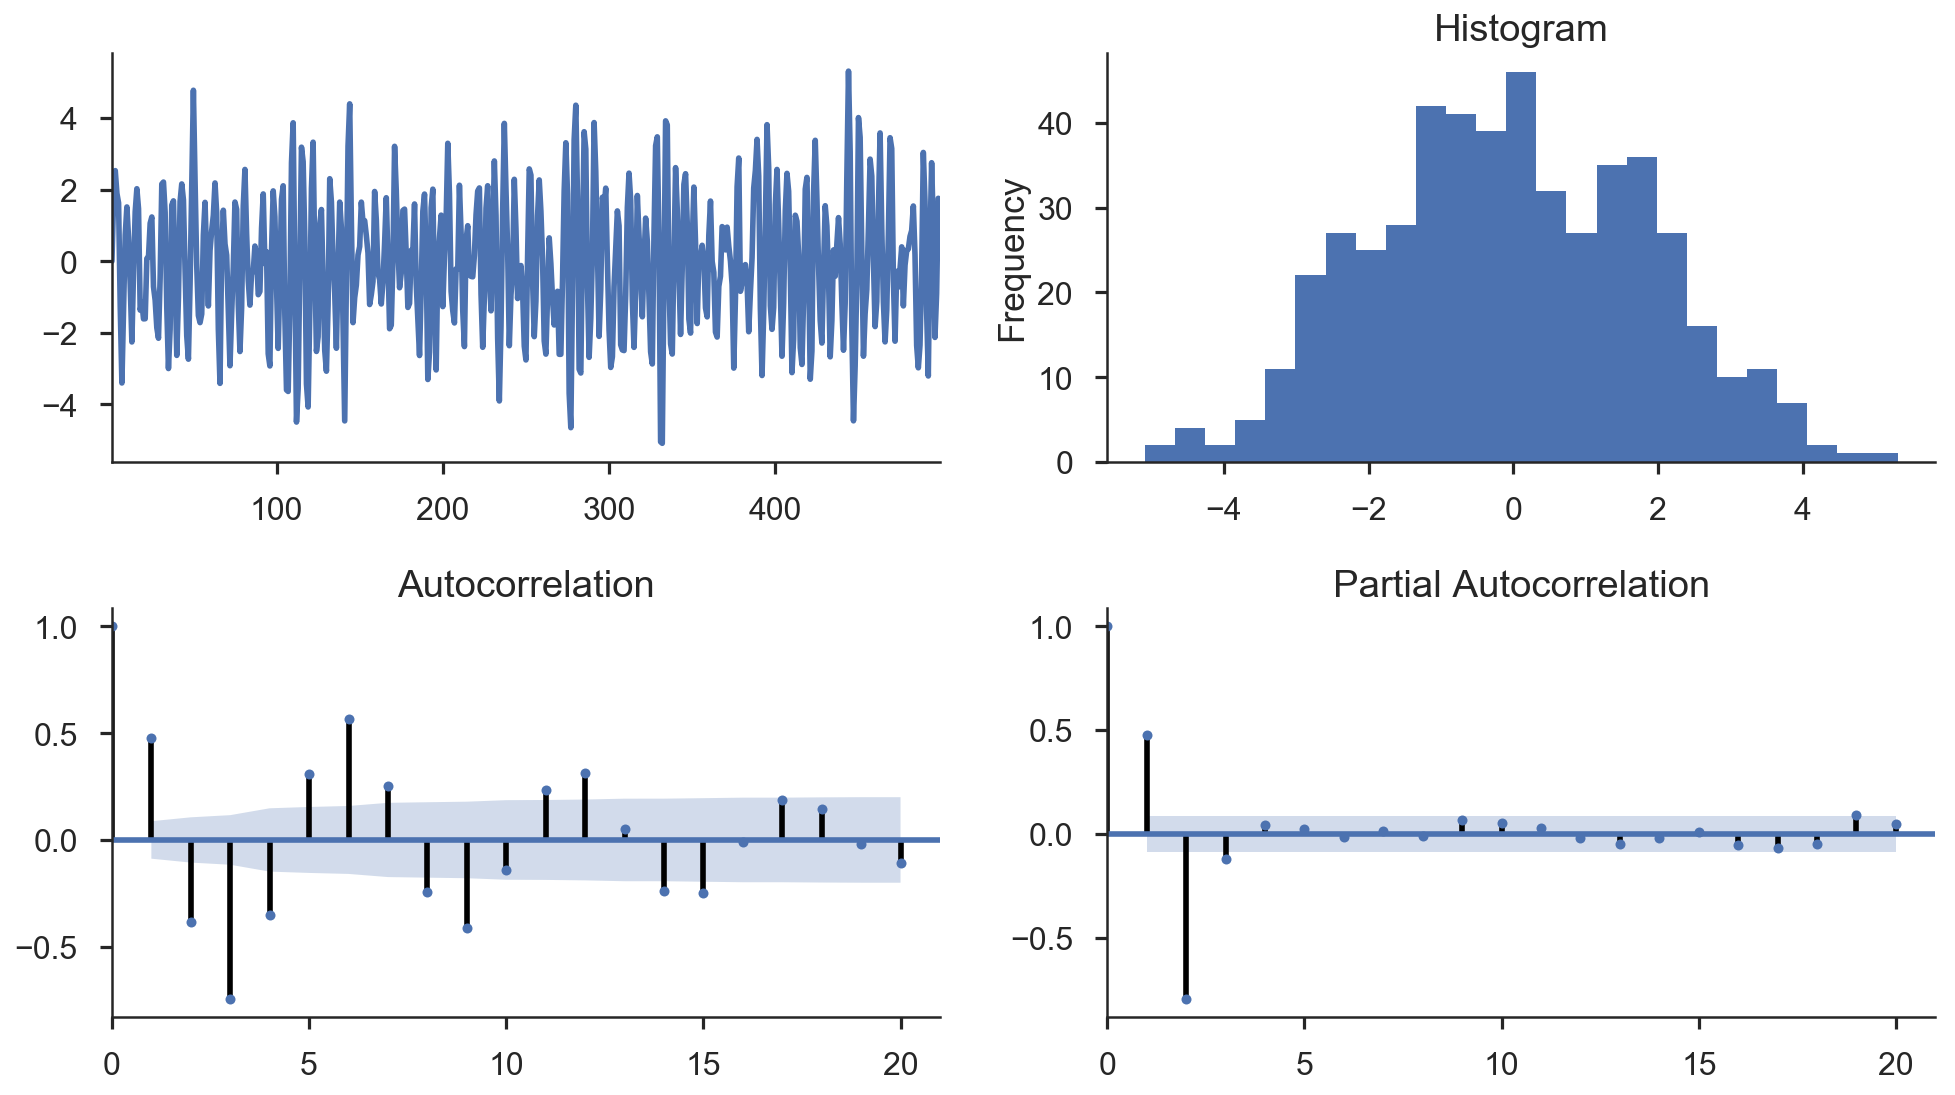

In [14]:
tsplot(ar2(phi1 = .9, phi2 = -.8, n = 500), lags = 20)

### 2.3 Seasonality

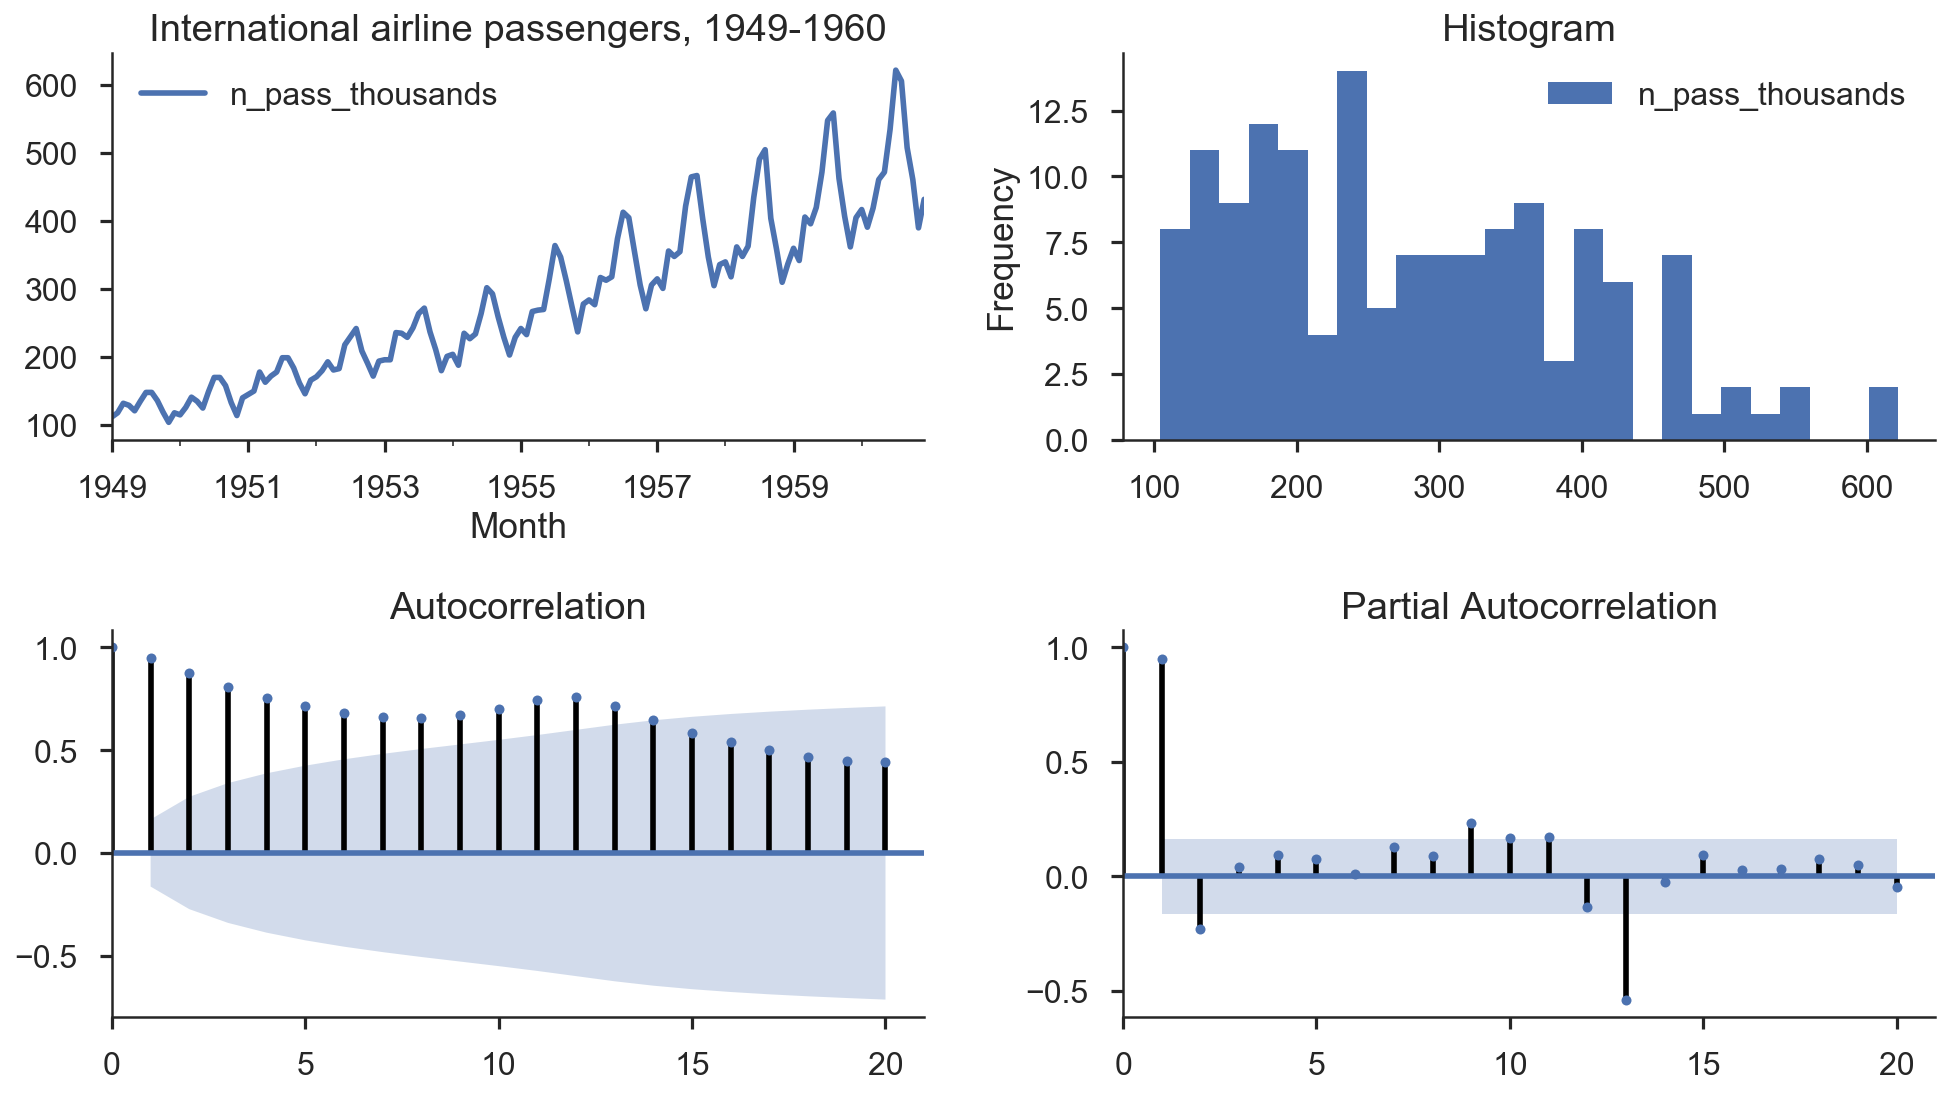

In [15]:
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])
tsplot(air, title='International airline passengers, 1949-1960', lags=20);

Month
1949-01-01   4.71850
1949-02-01   4.77068
1949-03-01   4.88280
1949-04-01   4.85981
1949-05-01   4.79579
Name: lnair, dtype: float64 

(144,) 

Month
1949-02-01    0.05219
1949-03-01    0.11212
1949-04-01   -0.02299
1949-05-01   -0.06402
1949-06-01    0.10948
Name: lnair, dtype: float64 

(143,) 



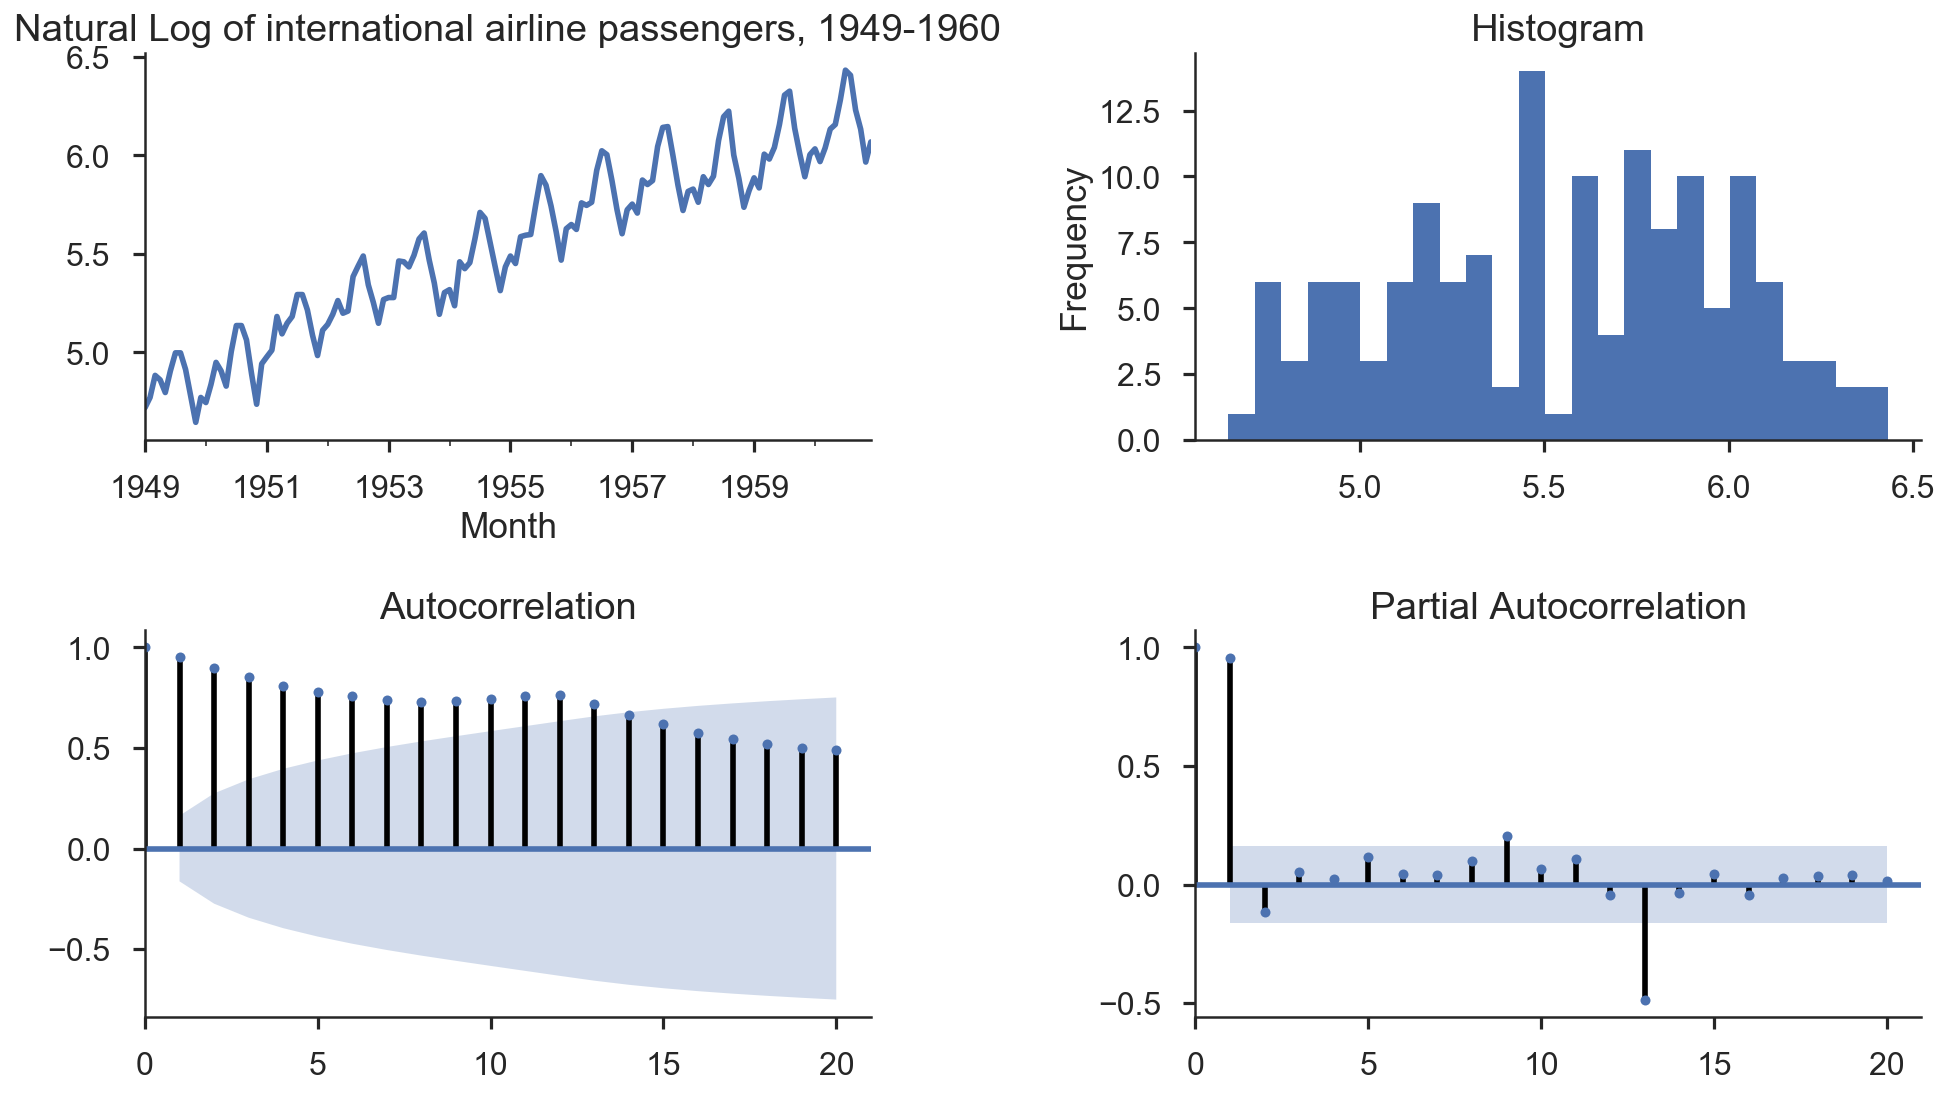

In [16]:
# Take log of the series
air['lnair'] = np.log(air)
print(air['lnair'].head(),"\n")
print(air['lnair'].shape,"\n")

# Take first difference of the series
#air_ln_diff = air['lnair'].diff() - air['lnair'].shift()
air_ln_diff = air['lnair'].diff()
air_ln_diff = air_ln_diff.dropna()
print(air_ln_diff.head(),"\n")
print(air_ln_diff.shape,"\n")
tsplot(air['lnair'], title='Natural Log of international airline passengers, 1949-1960', lags=20);

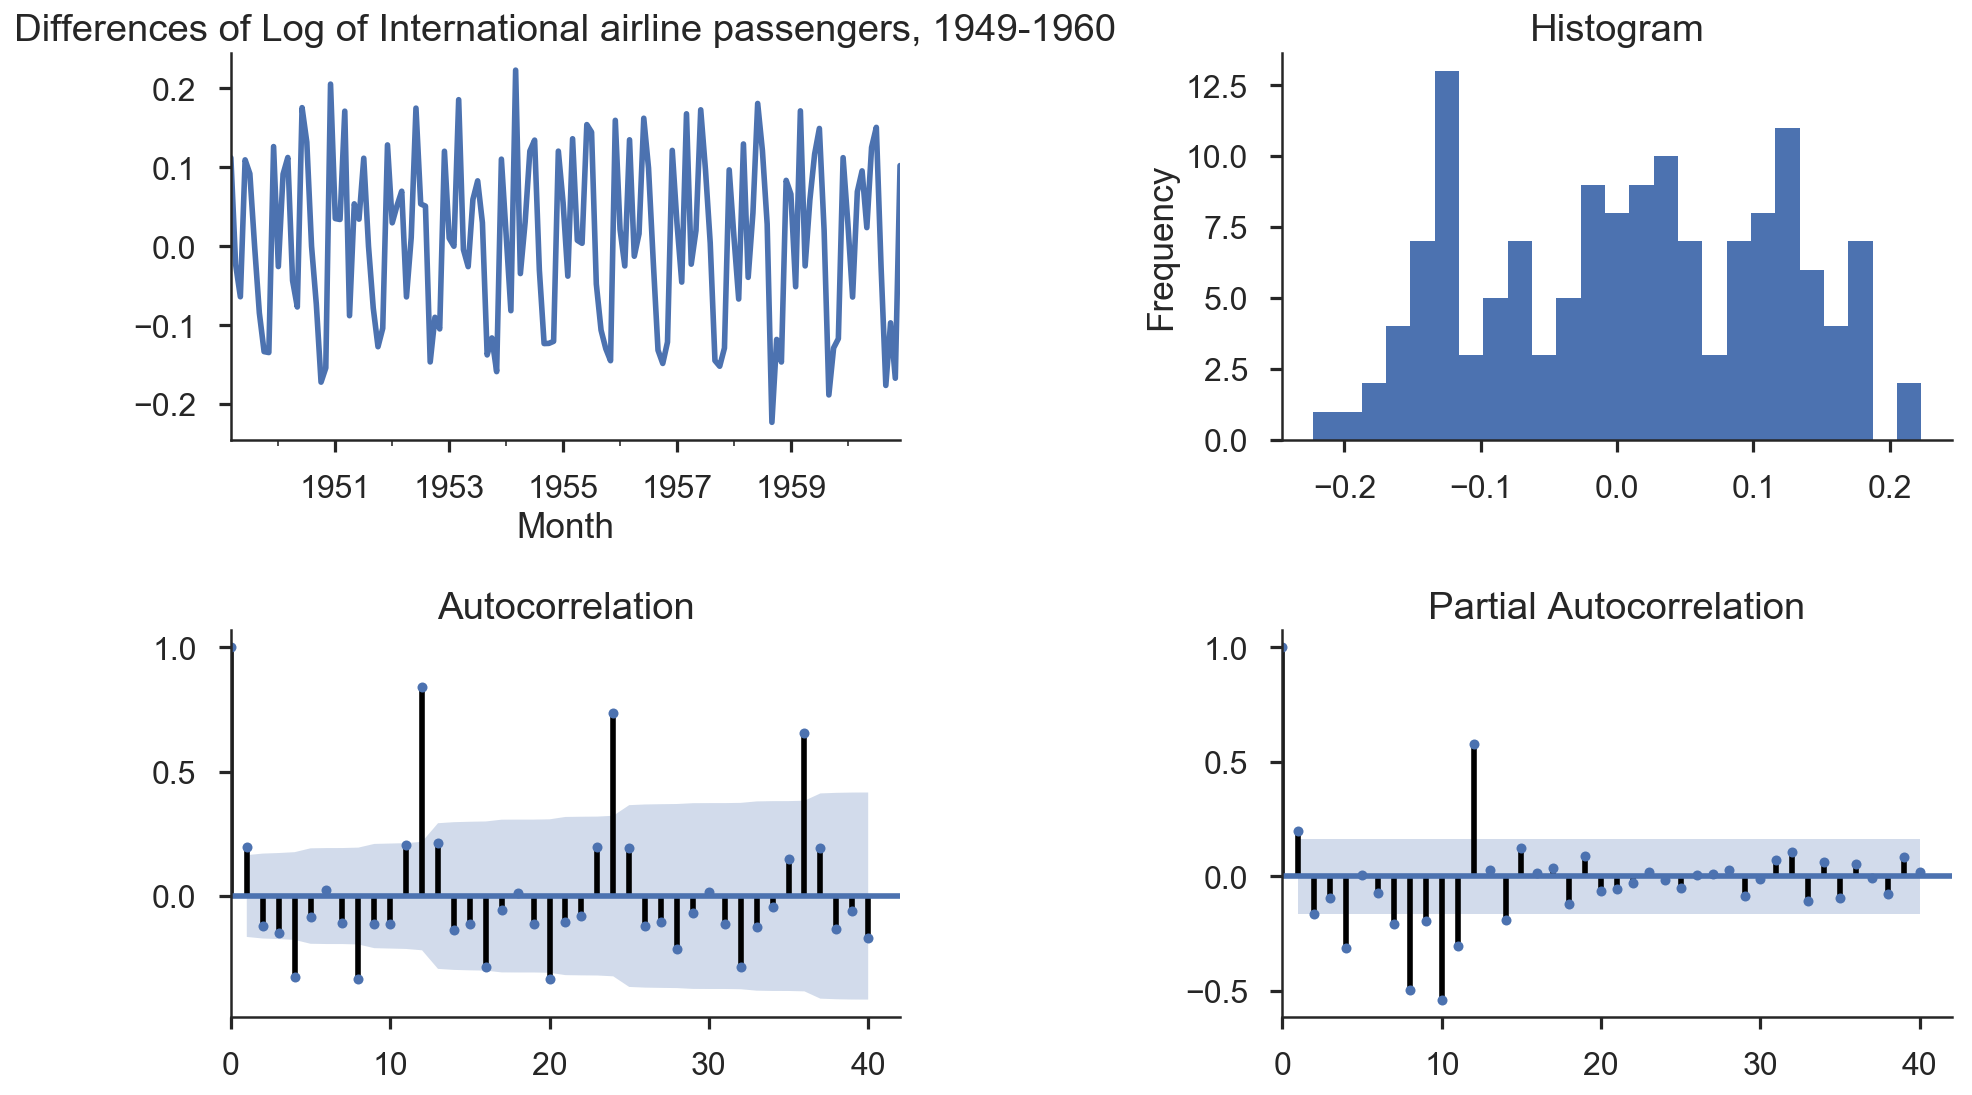

In [17]:
tsplot(air_ln_diff[1:], title='Differences of Log of International airline passengers, 1949-1960', lags=40);

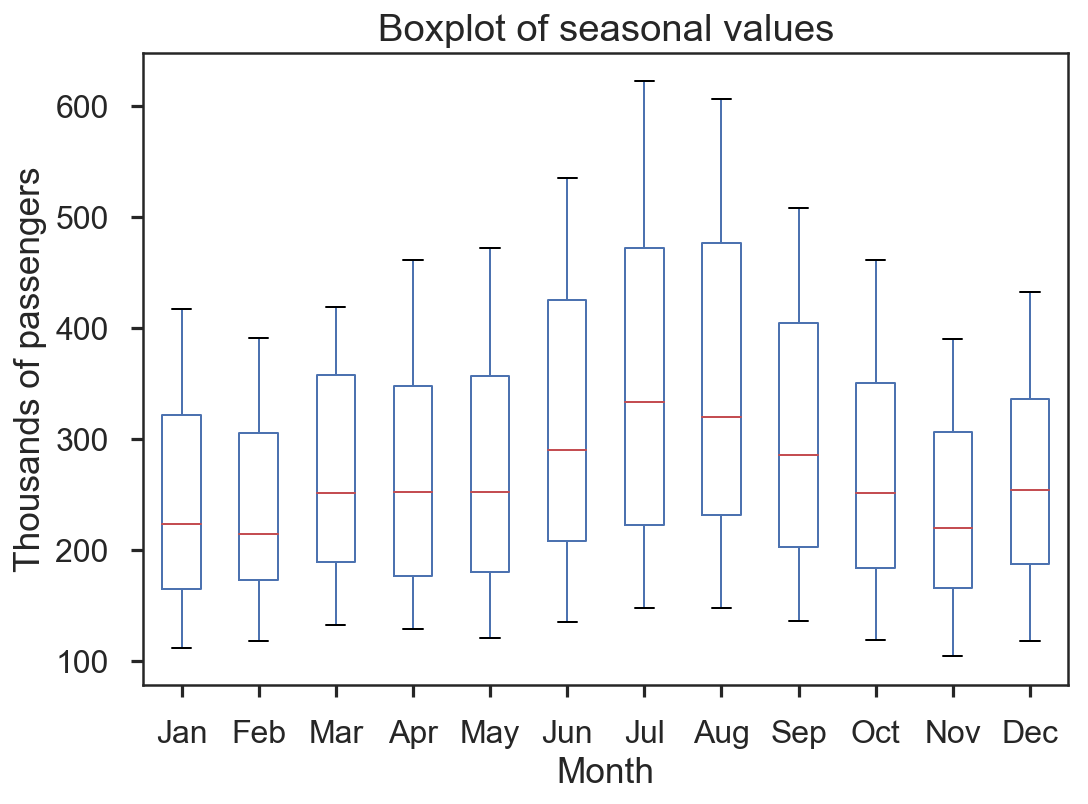

In [18]:
# An alternative way to detect seasonality

air['Month'] = air.index.strftime('%b')
air['Year'] = air.index.year

air_piv = air.pivot(index='Year', columns='Month', values='n_pass_thousands')

air = air.drop(['Month', 'Year'], axis=1)

# put the months in order
month_names = pd.date_range(start='2016-01-01', periods=12, freq='MS').strftime('%b')
air_piv = air_piv.reindex(columns=month_names)

# plot it
fig, ax = plt.subplots(figsize=(8, 6))
air_piv.plot(ax=ax, kind='box');

ax.set_xlabel('Month');
ax.set_ylabel('Thousands of passengers');
ax.set_title('Boxplot of seasonal values');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### 2.4 White Noise
$\omega_t $

(<matplotlib.axes._subplots.AxesSubplot at 0x121afd630>,
 <matplotlib.axes._subplots.AxesSubplot at 0x125ead3c8>)

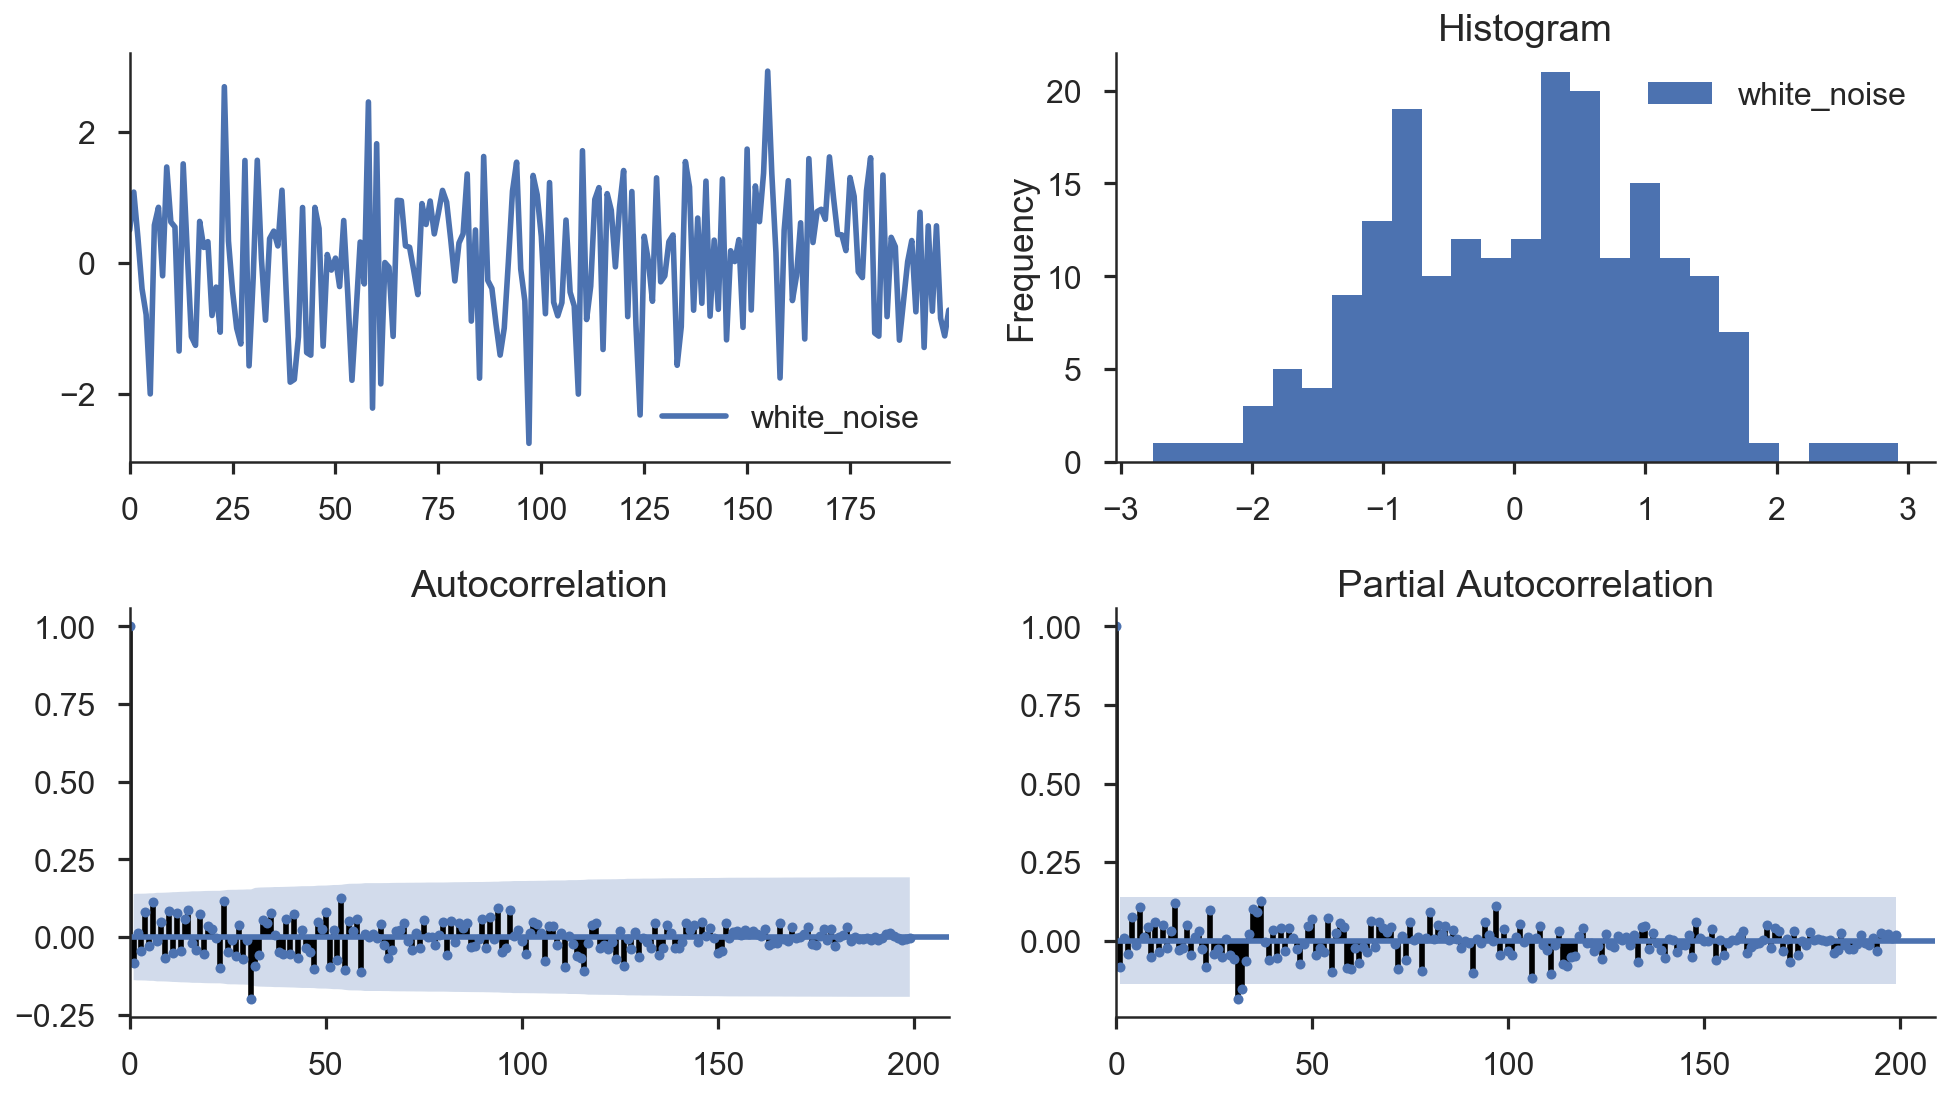

In [19]:
noise = np.random.normal(loc=0.0, scale=1.0, size=200)
noise_df = pd.DataFrame(data = {'white_noise' : noise})
tsplot(noise_df)

### 2.5 Random Walk
$x_t =  x_{t-1} + \omega_t $

(<matplotlib.axes._subplots.AxesSubplot at 0x12696fe48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x124b24cc0>)

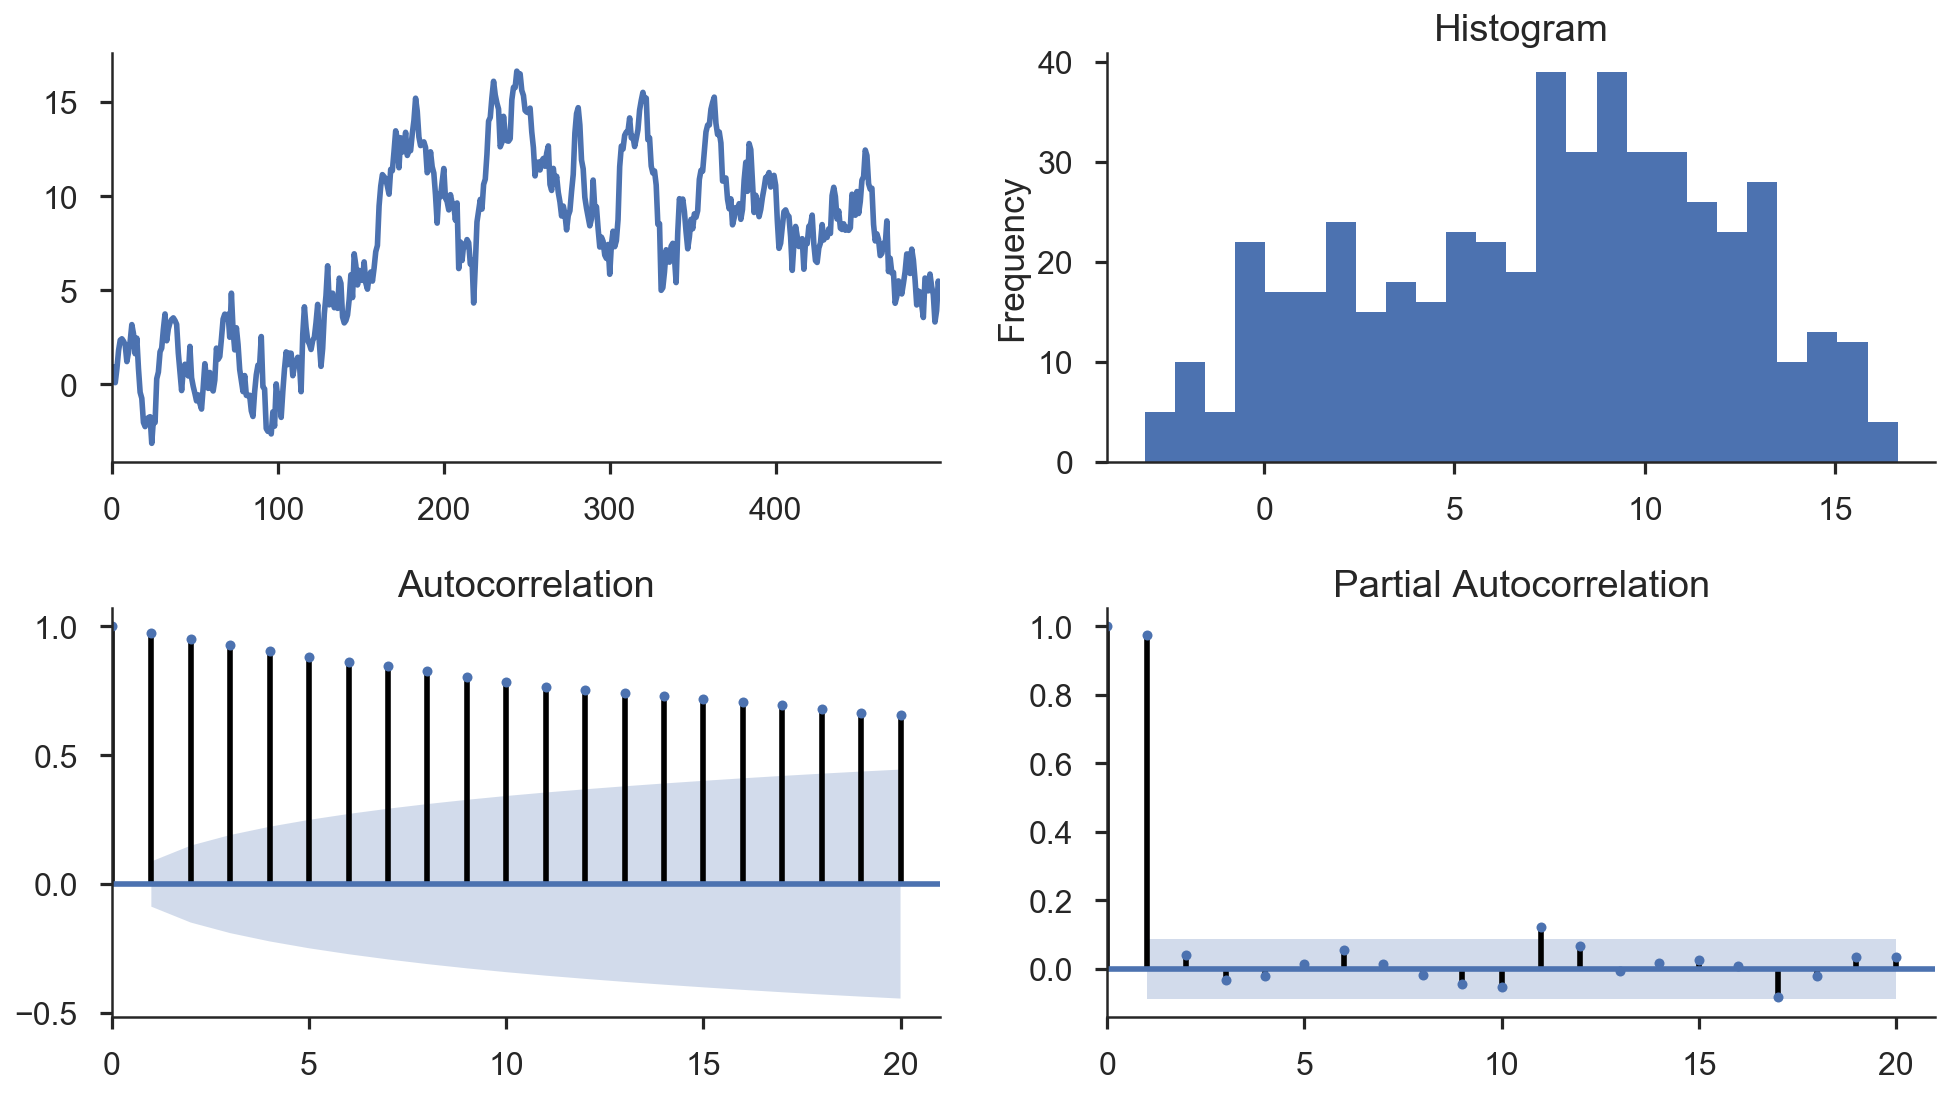

In [20]:
tsplot(ar1(phi = 1, n = 500), lags = 20)

# 3. Some basic Time Series models you need to know.
### 3.1 AR(p), MA(q)
### 3.2 ARIMA(p, d, q)
### 3.3 Seasonal ARIMA(p, d, q) * (P, D, Q)s

### 3.1 AR(p), MA(q)

Autoregressive model (AR)

$\textbf{AR(1):}$
$x_t = \phi_1 x_{t-1} + \omega_t $

$\textbf{AR(2):}$
$x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \omega_t $

$\textbf{AR(p):}$
$x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + \omega_t $

Moving Average model (MA)

$\textbf{MA(1):}$
$x_t = \omega_t + \theta_1 \omega_{t-1}$

$\textbf{MA(2):}$
$x_t = \omega_t + \theta_1 \omega_{t-1} + \theta_2 \omega_{t-2}$

$\textbf{MA(q):}$
$x_t = \omega_t + \theta_1 \omega_{t-1} + \theta_2 \omega_{t-2} + ... + \theta_q \omega_{t-q}$

$\textbf{ARMA(1,1):}$
$x_t = \phi_1 x_{t-1} + \omega_t + \theta_1 \omega_{t-1}$

$\textbf{It is equivalent to}$ 
$(1-\phi_1 B)x_t = (1+\theta_1 B)\omega_t$



(<matplotlib.axes._subplots.AxesSubplot at 0x124b31400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x124a3a518>)

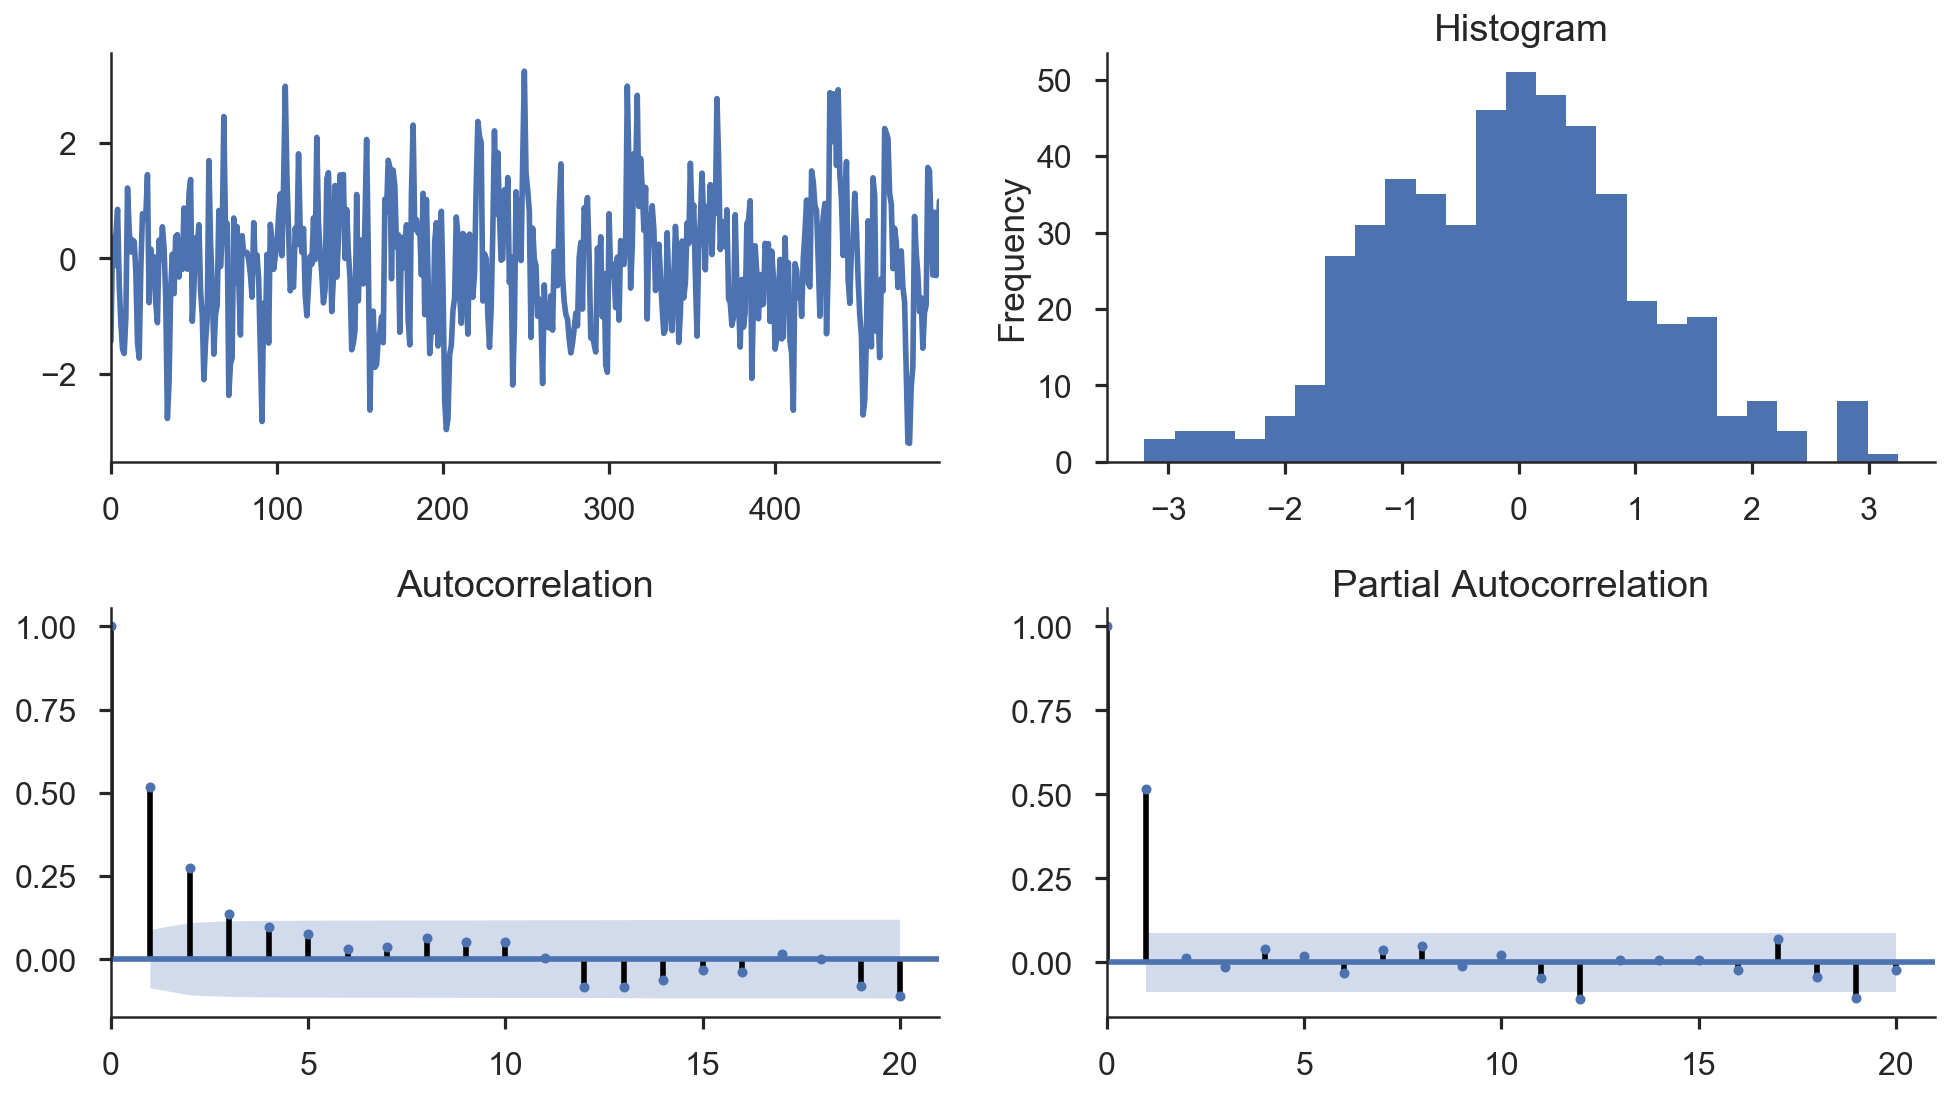

In [21]:
tsplot(ar1(phi = 0.5, n = 500), lags = 20)

(<matplotlib.axes._subplots.AxesSubplot at 0x120a68908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120b40ef0>)

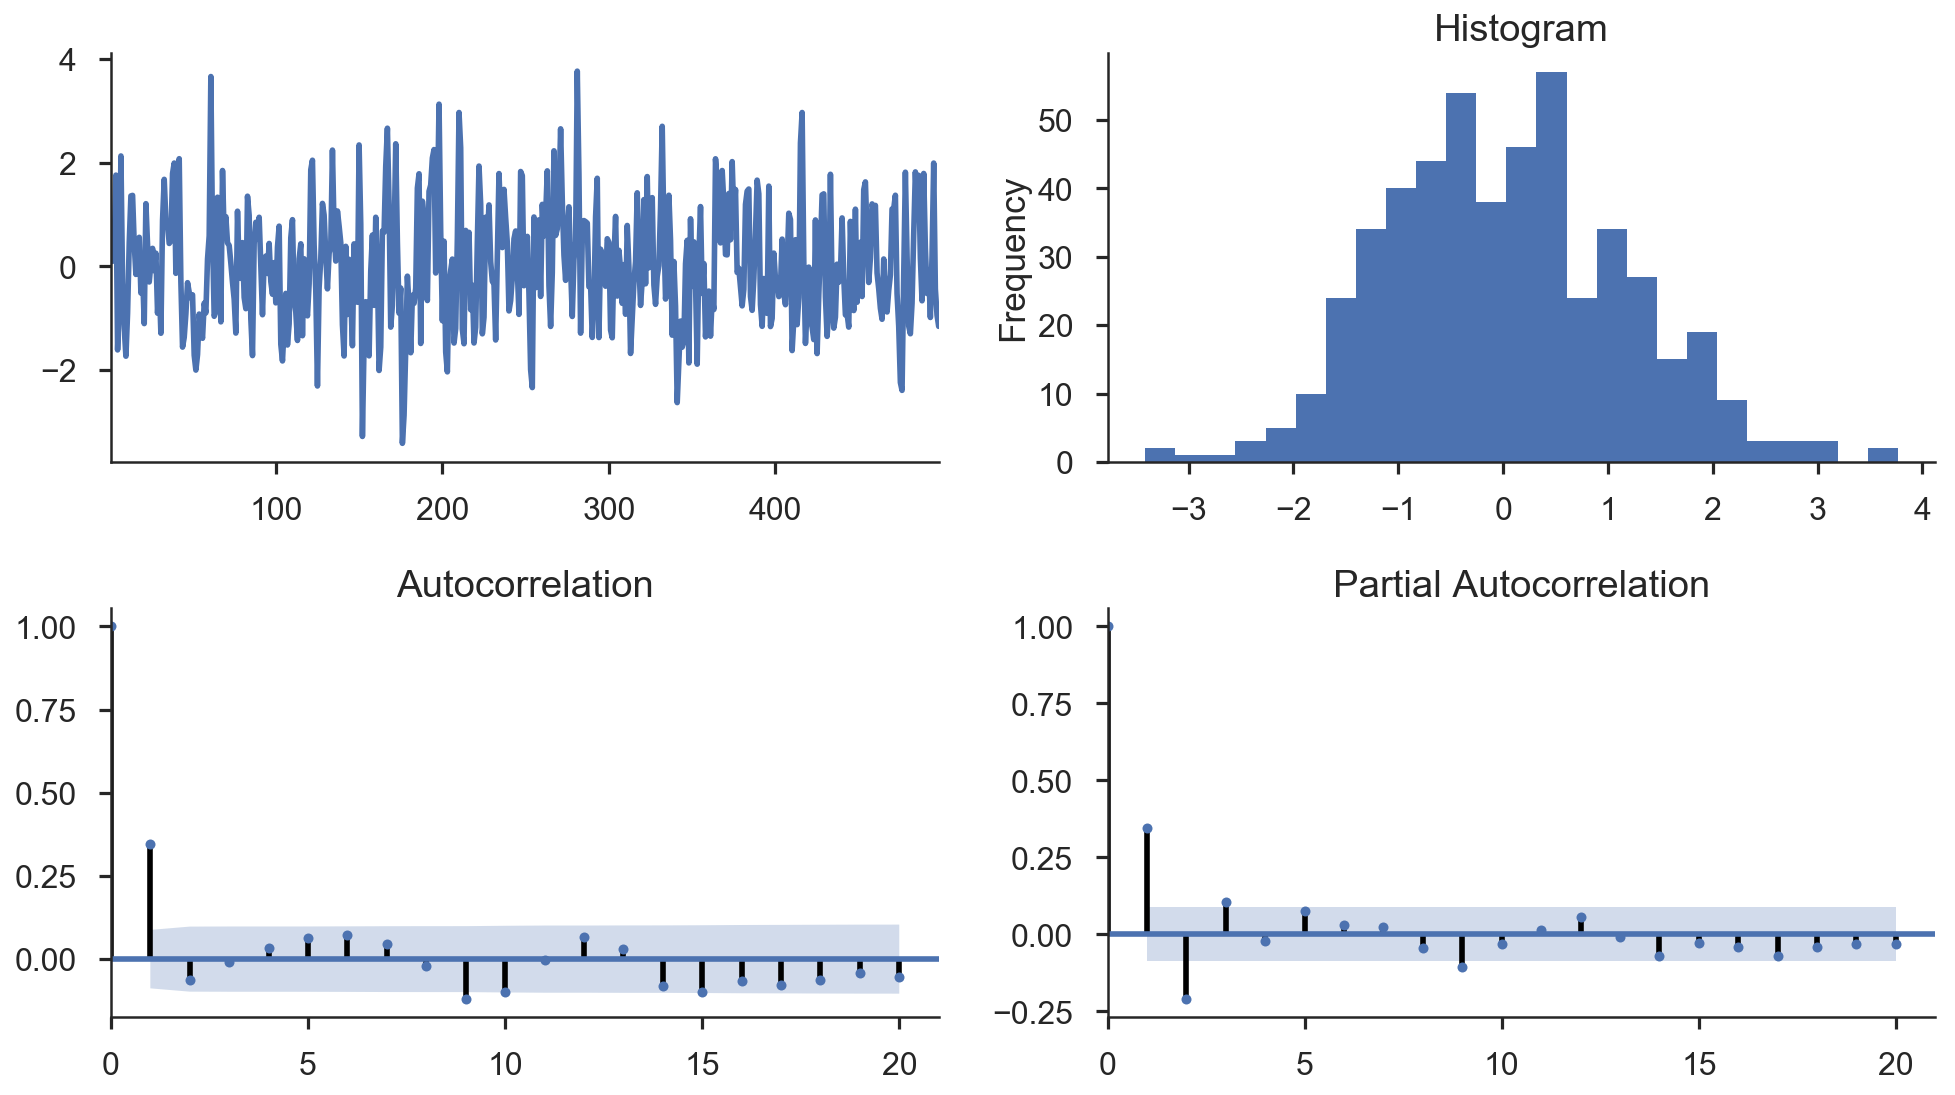

In [22]:
tsplot(ma1(theta = 0.5, n = 500), lags = 20)

### 3.2 ARIMA(p, d, q)


* A time series ${z_t}$ follows an ARIMA$(p,d,q)$ process if the $d^{th}$ differences of the ${z_t}$ series is an ARMA($p,q$) process. Using lag operator, it can expressed as 

$$\begin{equation}
  \phi_p(B)(1-B)^d z_t = \theta_q(B) \omega_t
\end{equation}$$

where $\phi_p$ and $\theta_q$ are polynomials of orders $p$ and $q$.

* Writing an ARIMA$(p,d,q)$ may seem too abstract, and whenever a model is presented this way, you may get a feel of the model by making simple cases, such as a low order ARIMA$(p,d,q)$ model. 



* Below show two such examples to unpack some of these notations:

$\textbf{Example 1:}$
Consider the model $ z_t = z_{t-1} + \omega_t + \theta \omega_{t-1}$.  Re-write this model using lag (or backward shift) operator. By now, we should be familiar with this kind of manipulation:

$$\begin{align}
   z_t &= z_{t-1} + \omega_t + \theta \omega_{t-1} \\
   z_t - z_{t-1} &= \omega_t + \theta \omega_{t-1} \\
  (1-B)z_t &= (1+\theta B)\omega_t
\end{align}$$

where $B$ is a lag operator that when applying to $z_t$, gives $z_{t-1}$. That is, $Bz_t = z_{t-1}$.

* This becomes an ARIMA(0,1,1) model, or $\textit{integrated moving average}$ model (IMA(1,1)).

$\textbf{Example 2:}$
Consider a model of the form

$$\begin{equation}
     z_t = \phi z_{t-1} + z_{t-1} - \phi z_{t-2} + \omega_t
\end{equation}$$

* Rewrite the equation, re-arrange terms, and factorize them:

$$\begin{align}
   z_t - z_{t-1} &= \phi (z_{t-1} - z_{t-2}) + \omega_t \\
   (z_t - z_{t-1}) - \phi (z_{t-1} - z_{t-2}) &= \omega_t \\
   (1 - \phi B)(z_t - z_{t-1}) &=  \omega_t \\
   (1 - \phi B) \bigtriangledown z_t &=  \omega_t \\
   (1 - \phi B)(1 - B)z_t  &= \omega_t
\end{align}$$

The model can be re-written as $(1 - \phi B) \bigtriangledown y_t  = \omega_t$, which is an ARIMA(1,1,0) model.

**Sidenotes**

A series ${z_t}$ is $\textit{integrated}$ of order $d$, denoted as $I(d)$, if the $d^{th}$ differences of ${z_t}$ is a white noise: $\bigtriangledown^d y_t = \omega_t$, where $\bigtriangledown^d \equiv (1-B)^d$:

$$\begin{equation}
  (1-B)^d y_t = \omega_t
\end{equation}$$

As such, random walk is the special case I(1).

* In practice, I(0) and I(1) cases find themselves having the most applications.


### 3.3 Seasonal ARIMA(p, d, q) * (P, D, Q)s


The *pure* seasonal autoregressive and moving average model, $ARMA(P,Q)$, take the from

$$\Phi_P(B^s)z_t=\Theta_Q(B^s)\epsilon_t$$ 

where 

$$\Phi_P(B^2)=1 - \Phi_1 B^s - \Phi_2 B^{2s} - \cdots - \Phi_P B^{Ps}$$

and 

$$\Theta_Q(B^2)=1 - \Theta_1 B^s - \Theta_2 B^{2s} - \cdots - \Theta_Q B^{Qs}$$

are the **seasonal autoregressive operator** and the **seasonal moving average operator** of orders $P$ and $Q$ with **seasonal period s**.

**Example:**

A first-order seasonal autoregressive moving average series over months (or $SARIMA(1,0,1,12)$) can be expressed as

$$ z_t = \Phi z_{t-12} + \epsilon_t + \Theta \epsilon_{t-12} $$

or

$$ (1 - \Phi B^{12})z_t = (1 + \Theta B^{12})\epsilon_t $$

In other words, this model capture the relationship between $z_t$ and its lags at the multiple of the yearly seasonal period $s=12$ months.  

The stationarity condition requires that $|\Phi|<1$ and the invertible condition requires that $|\Theta|<1$.

Similar to that for the ARIMA models, the table below summarize the behavior of the theoretical ACF and PACF of the pure seasonal ARMA models:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(P)**     |    tails off         | cutoff after lag $P$ |
| **MA(Q)**     | cutoff after lag $Q$ |    tails off         |
| **ARMA(P,Q)** |    tails off         |    tails off         |

* **Note that we use (p,d,q) to denote the orders for the non-seasonal components of the ARIMA models and (P,D,Q,s) to denote the orders for the seasonal components of the ARIMA model.**

The general formulation of the **Multiplicative Seasonal Autoregressive Integrated Moving Average (SARIMA)** model takes the following form:

$$ \phi_p(B) \Phi_P(B^s) \bigtriangledown^d \bigtriangledown^D_s z_t = \theta_q(B) \Theta_Q(B^s) \epsilon_t $$ 

where 

$\epsilon_t$ is a white noise process

$\phi_p(B)$ and $\theta_q(B)$ are non-seasonal autoregressive and moving average lag polynomials

$\Phi_P(B^s)$ and $\Theta_Q(B^s)$ are seasonal autoregressive and moving average lag polynomials

$\bigtriangledown^d \equiv (1-B)^d$ and $\bigtriangledown^D_s \equiv (1-B^s)^D$ are the difference (or integrated) components

Therefore, the general model is denoted as $\mathbf{ARIMA(p,d,q)\times(P,D,Q)_s}$



In [23]:
# Import the csv file containing the series for the analysis

filename_ts = 'data/series1.csv'
ts_df = pd.read_csv(filename_ts, index_col=0, parse_dates=[0])

n_sample = ts_df.shape[0]

In [24]:
print(ts_df.shape)
print(ts_df.head())

(120, 1)
              value
2006-06-01  0.21507
2006-07-01  1.14225
2006-08-01  0.08077
2006-09-01 -0.73952
2006-10-01  0.53552


In [25]:
# Create a training sample and testing sample before analyzing the series

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = ts_df.iloc[:n_train]['value']
ts_test = ts_df.iloc[n_train:]['value']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(115,)
(5,)
Training Series: 
 2015-08-01    0.60371
2015-09-01   -1.27372
2015-10-01   -0.93284
2015-11-01    0.08552
2015-12-01    1.20534
Name: value, dtype: float64 

Testing Series: 
 2016-01-01    2.16411
2016-02-01    0.95226
2016-03-01    0.36485
2016-04-01   -2.26487
2016-05-01   -2.38168
Name: value, dtype: float64


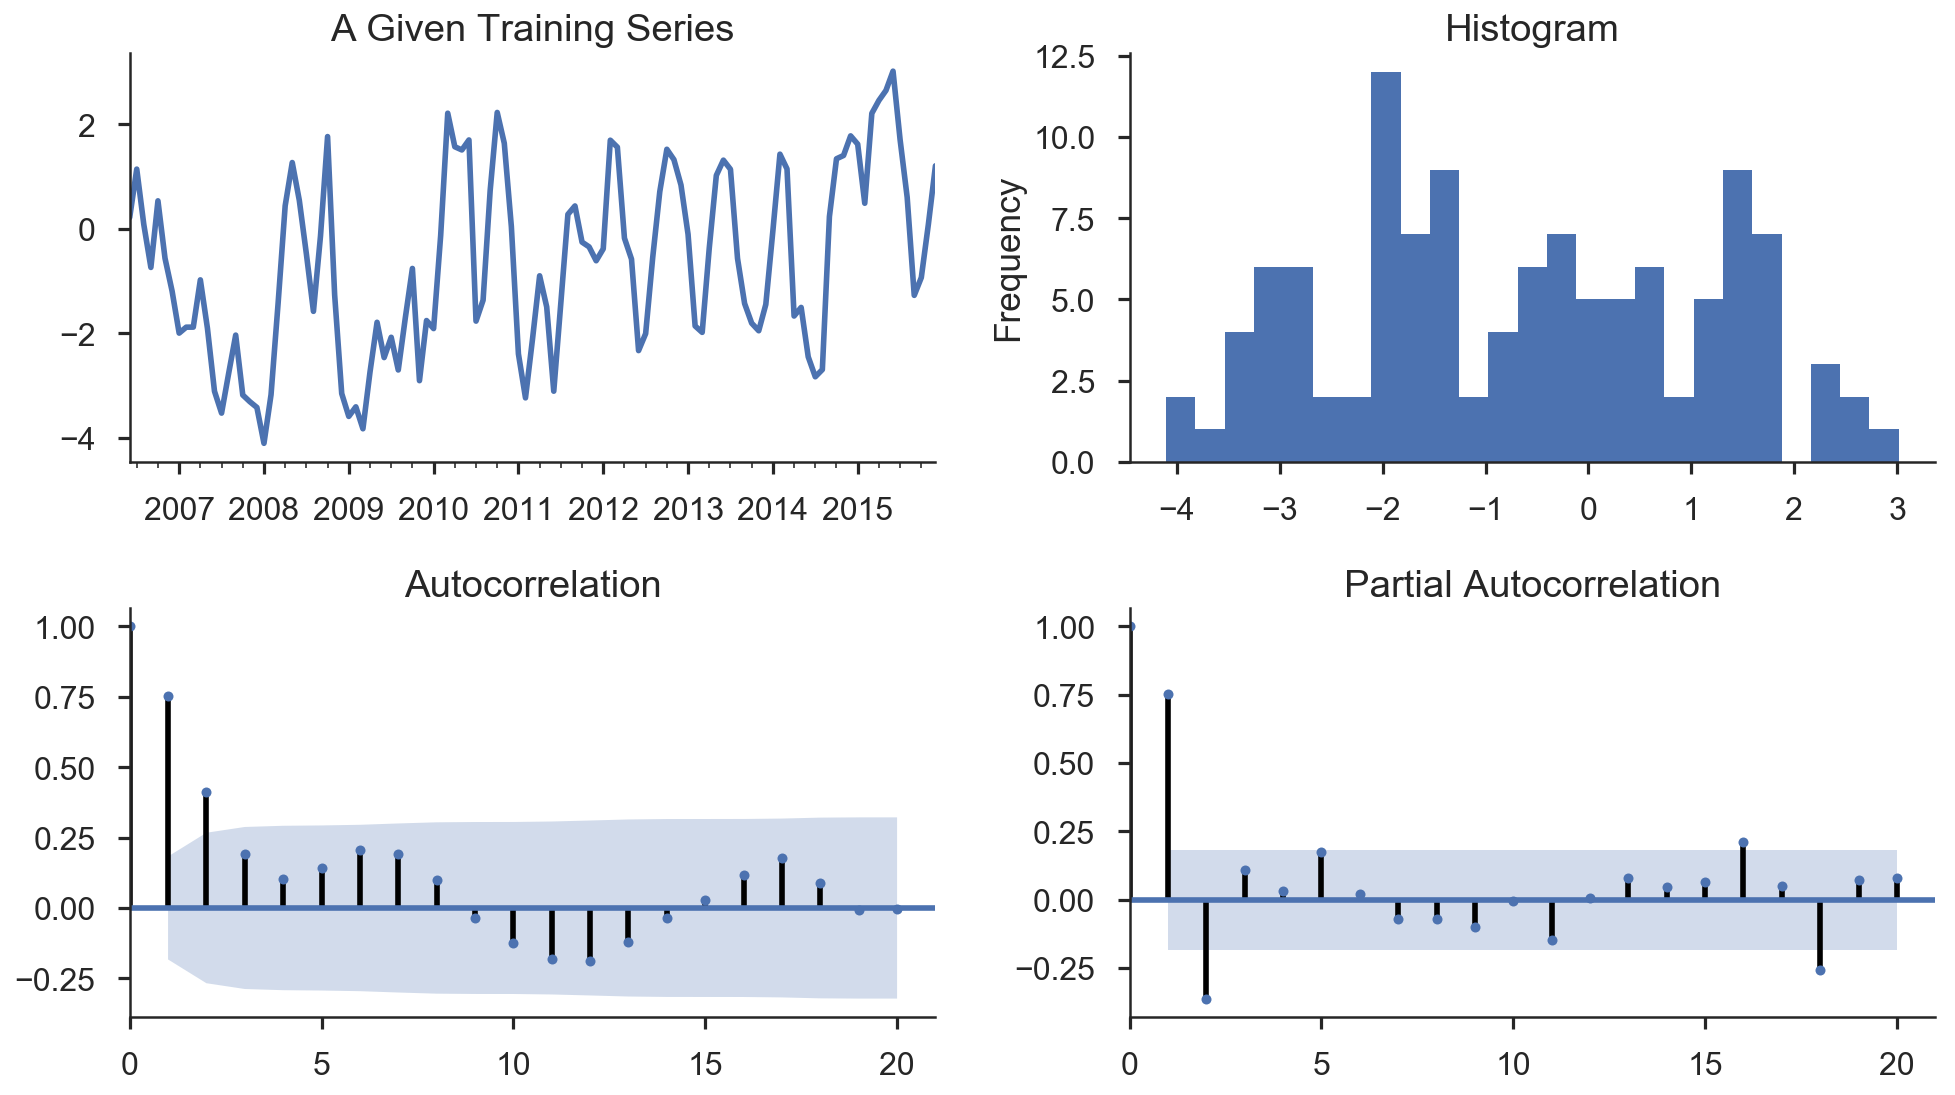

In [26]:
tsplot(ts_train, title='A Given Training Series', lags=20);

In [27]:
# Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,1,1))
model_results = arima200.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                  115
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -168.341
Date:                Fri, 08 Sep 2017   AIC                            344.681
Time:                        14:50:07   BIC                            355.661
Sample:                    06-01-2006   HQIC                           349.138
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0078      0.097     10.370      0.000       0.817       1.198
ar.L2         -0.4051      0.092     -4.413      0.000      -0.585      -0.225
ma.L1         -0.9439      0.056    -16.972      0.000      -1.053      -0.835
sigma2         1.1076      0.167      6.646      0.000       0.781       1.434
===================================================================================
Ljung-Box (Q):                       63.65   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.01   Prob(JB):                         0.80
Heteroskedasticity (H):               0.88   Skew:                            -0.12
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

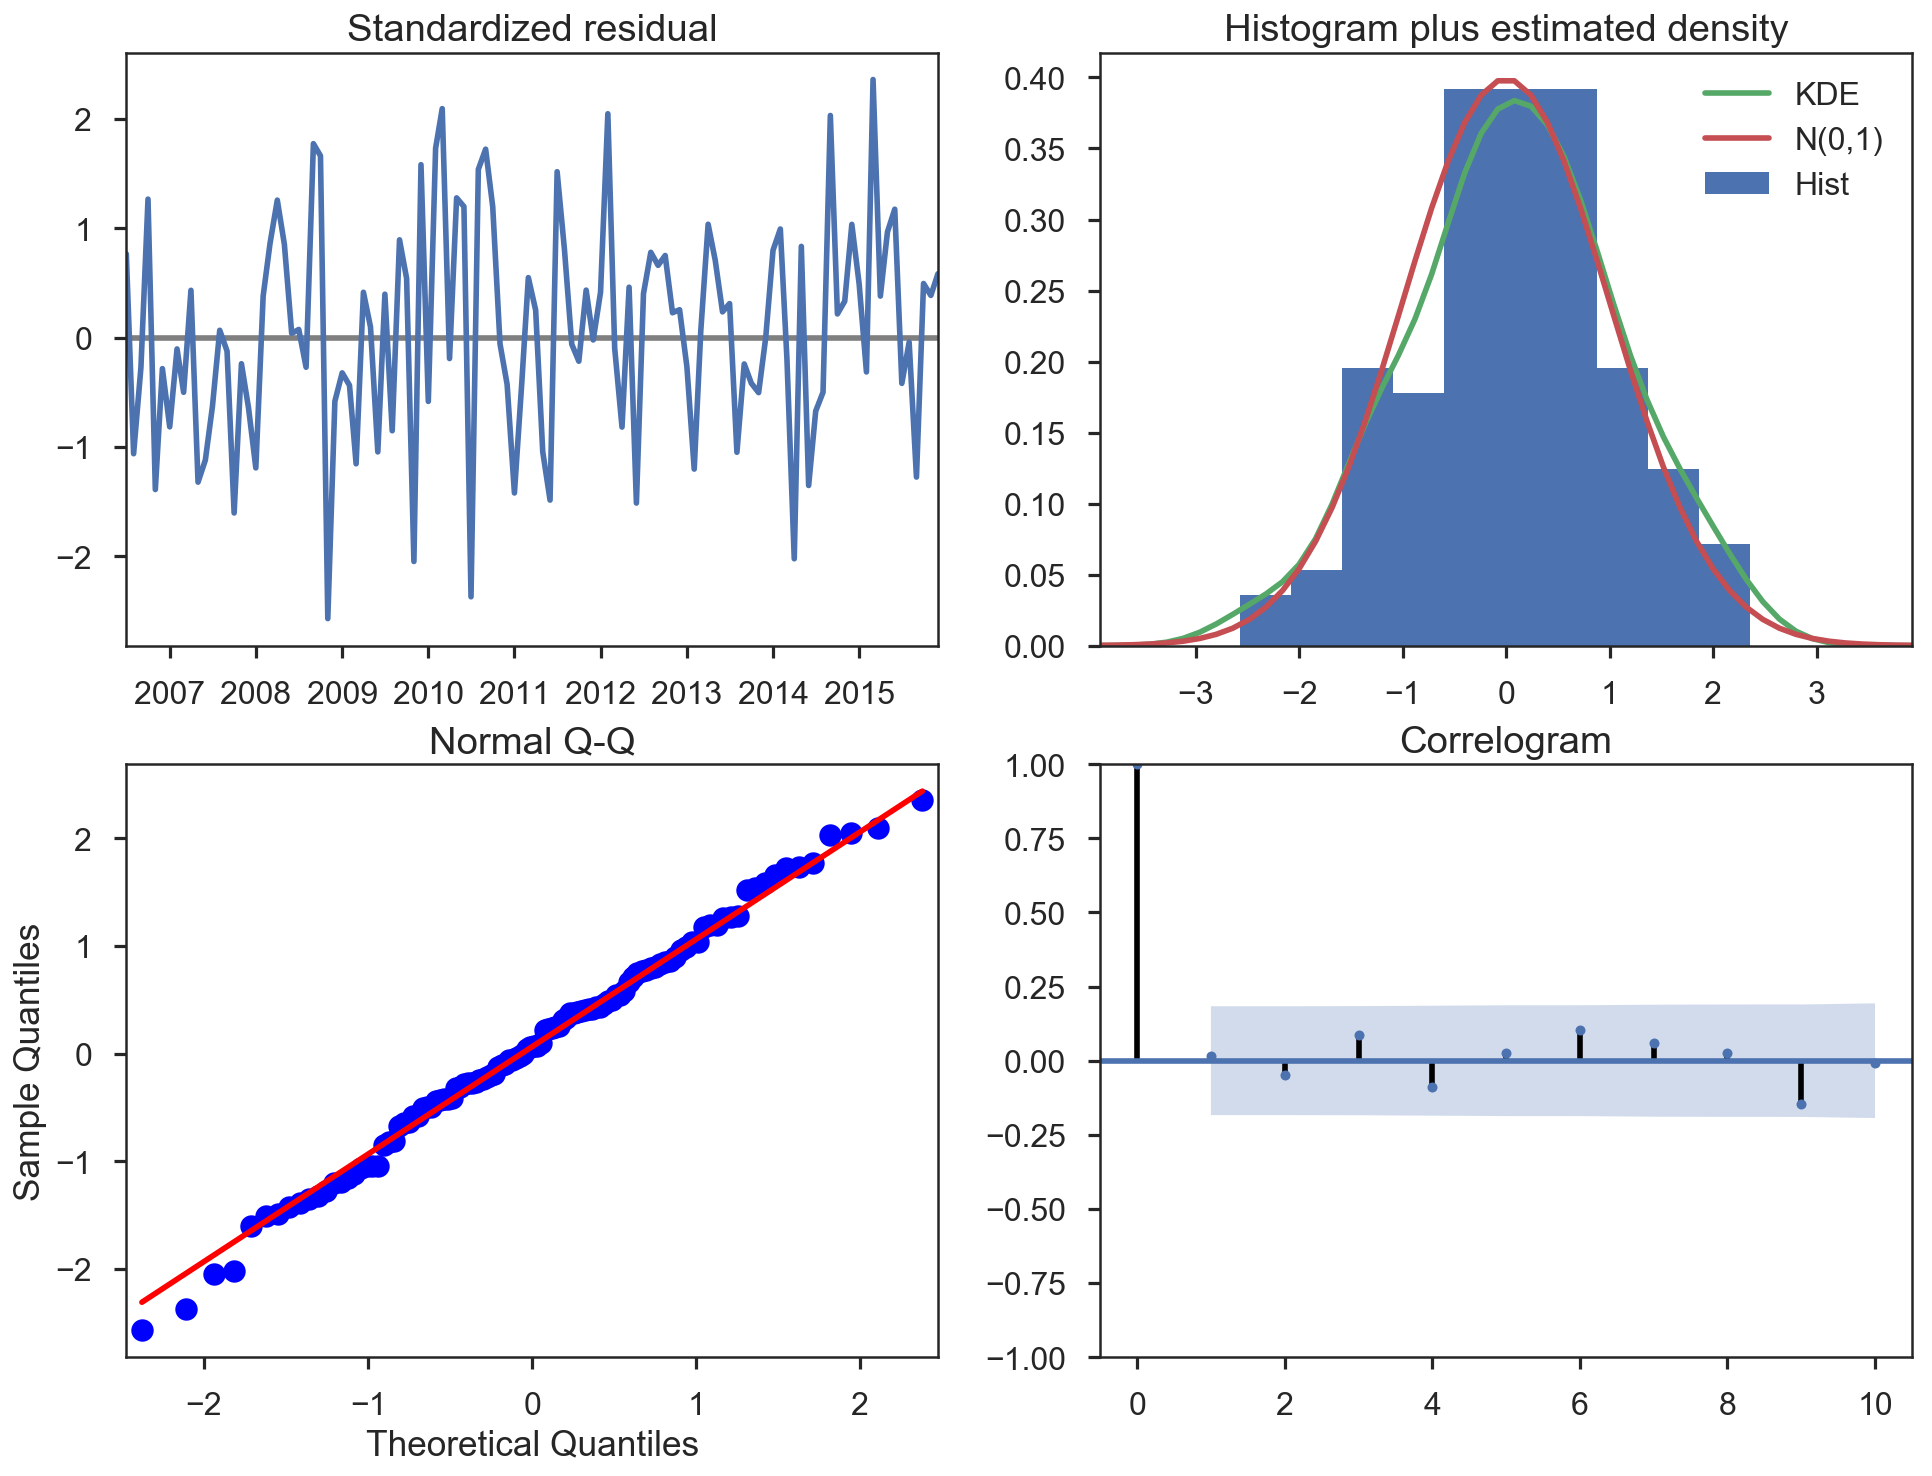

In [28]:
# Residual Diagnostics
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals

model_results.plot_diagnostics(figsize=(16, 12));

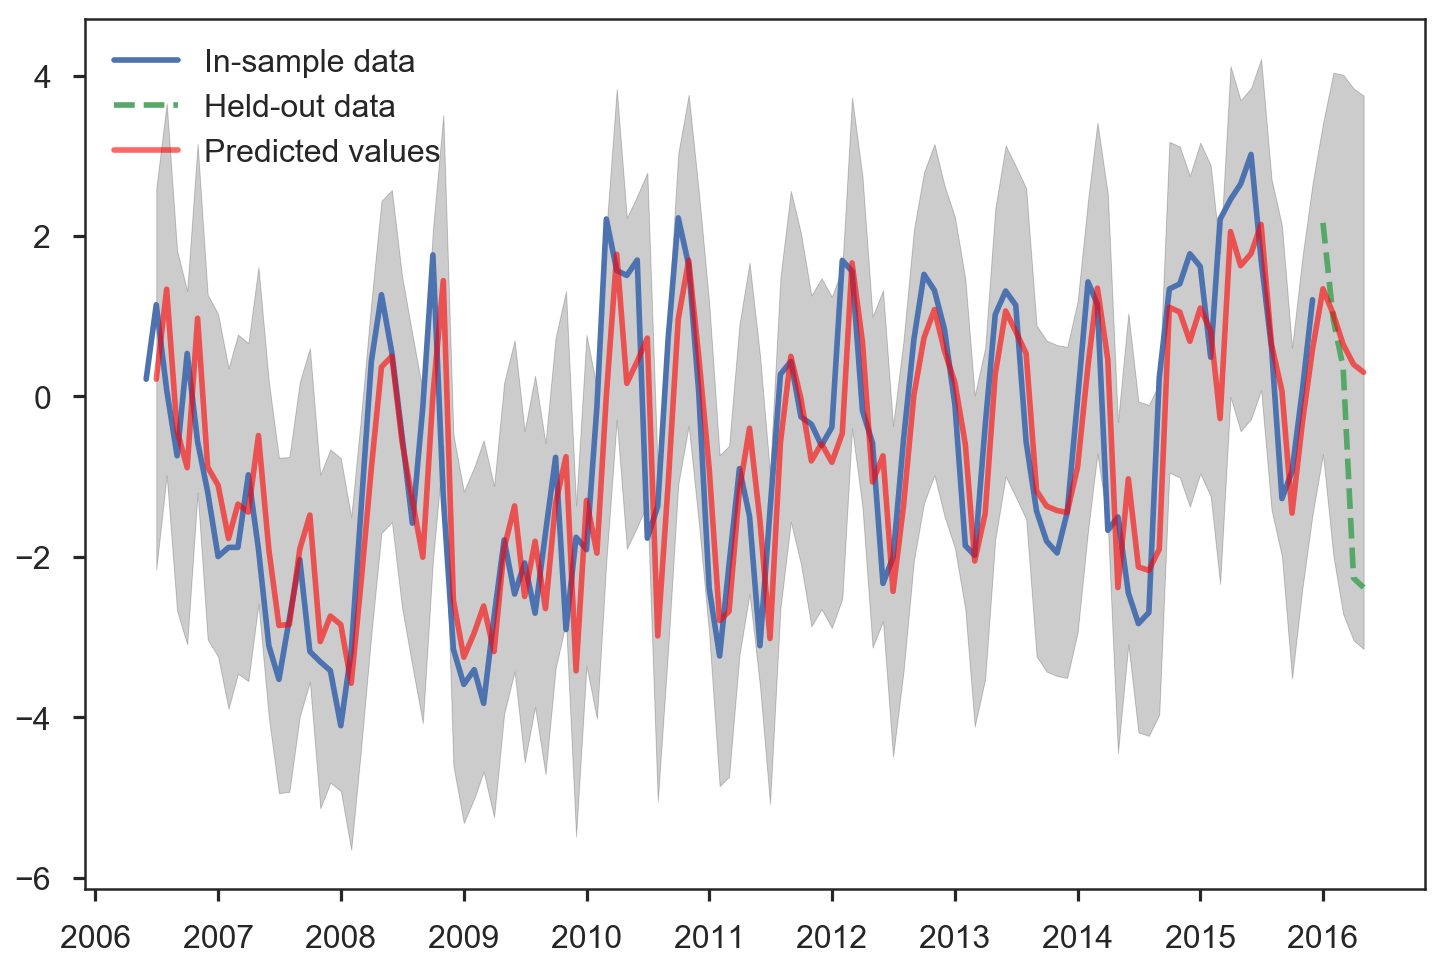

In [29]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [30]:
rmse_training = get_rmse(ts_train, pred_mean.loc[ts_train.index])
print("RMSE of training data: ", rmse_training)


RMSE of training data:  1.05840392139


In [31]:
rmse_testing = get_rmse(ts_test, pred_mean.loc[ts_test.index])
print("RMSE of testing data: ", rmse_testing)

RMSE of testing data:  1.73556064592


# 4. Let's get our hands dirty!

### 4.1 data exploration

#### 4.1.1 training - testing split
#### 4.1.2 stationarity
#### 4.1.3 ACF & PACF

(264,)
(29,)
Training Series: 
 Period
2013-08-01    4078
2013-09-01    3643
2013-10-01    3799
2013-11-01    4043
2013-12-01    5235
Name: Value, dtype: int64 

Testing Series: 
 Period
2014-01-01    3373
2014-02-01    3353
2014-03-01    3679
2014-04-01    3699
2014-05-01    4187
Name: Value, dtype: int64


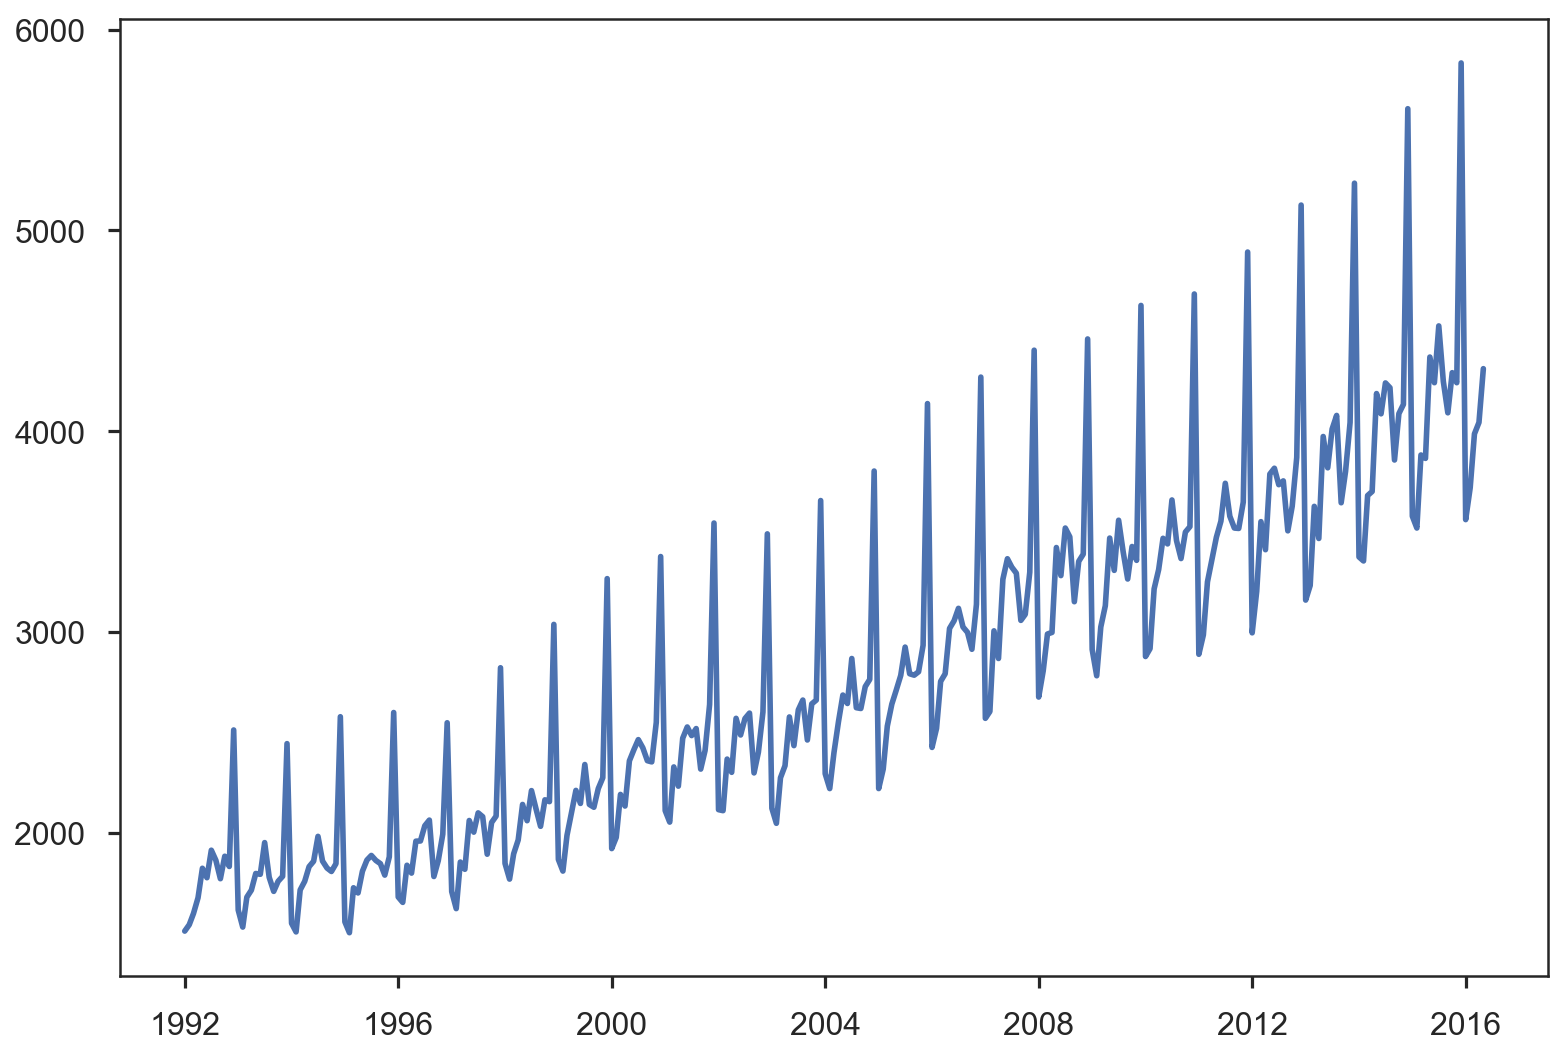

In [32]:
# Step 1: Import the data series
liquor = pd.read_csv('data/liquor.csv', header=0, index_col=0, parse_dates=[0])
plt.plot(liquor)
# Step 1b: Create the training and testing series before analyzing the series
n_sample = liquor.shape[0]
n_train=int(0.90*n_sample)+1
n_forecast=n_sample-n_train

liquor_train = liquor.iloc[:n_train]['Value']
liquor_test  = liquor.iloc[n_train:]['Value']
print(liquor_train.shape)
print(liquor_test.shape)
print("Training Series:", "\n", liquor_train.tail(), "\n")
print("Testing Series:", "\n", liquor_test.head())

(130,)
(14,)
Training Series: 
 Month
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
Name: n_pass_thousands, dtype: int64 

Testing Series: 
 Month
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
1960-03-01    419
Name: n_pass_thousands, dtype: int64


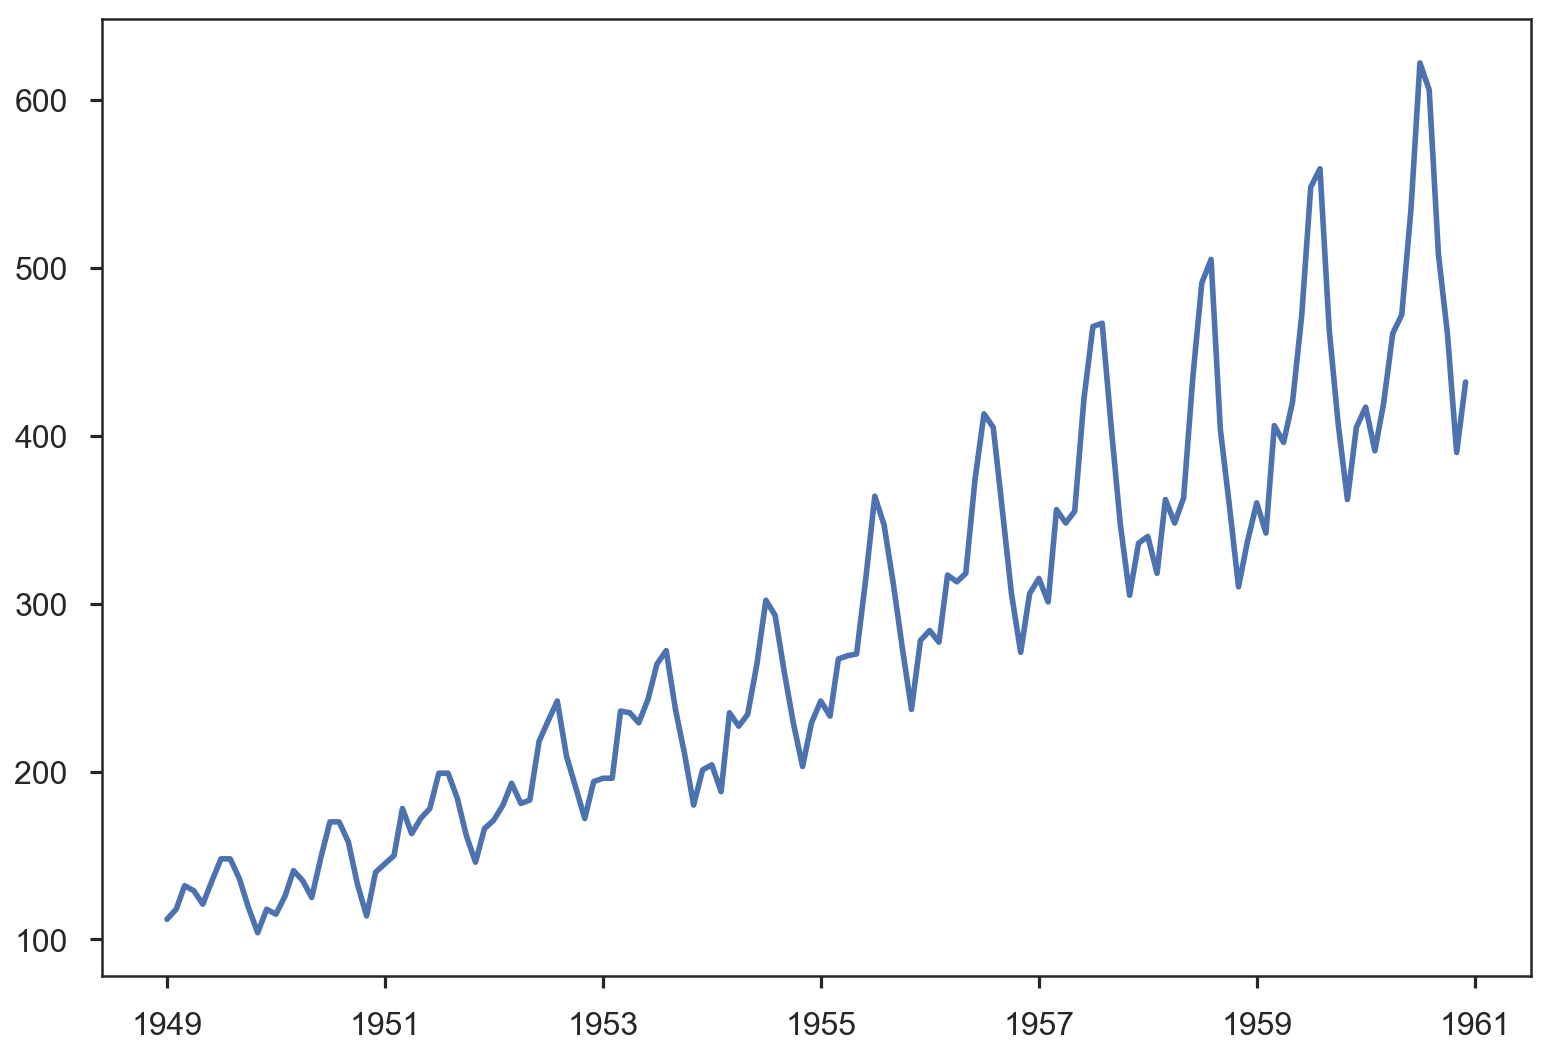

In [33]:
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])
plt.plot(air)
# Step 1b: Create the training and testing series before analyzing the series
n_sample = air.shape[0]
n_train=int(0.90*n_sample)+1
n_forecast=n_sample-n_train

air_train = air.iloc[:n_train]['n_pass_thousands']
air_test  = air.iloc[n_train:]['n_pass_thousands']
print(air_train.shape)
print(air_test.shape)
print("Training Series:", "\n", air_train.tail(), "\n")
print("Testing Series:", "\n", air_test.head())

In [34]:
# Step 2a: Examine the basic structure of the data
print("Data shape:", air_train.shape, "\n")
print("First 5 observations of the training data series:", "\n", air_train.head(), "\n")
print("Last 5 observations of the training data series:", "\n", air_train.tail())

Data shape: (130,) 

First 5 observations of the training data series: 
 Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: n_pass_thousands, dtype: int64 

Last 5 observations of the training data series: 
 Month
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
Name: n_pass_thousands, dtype: int64


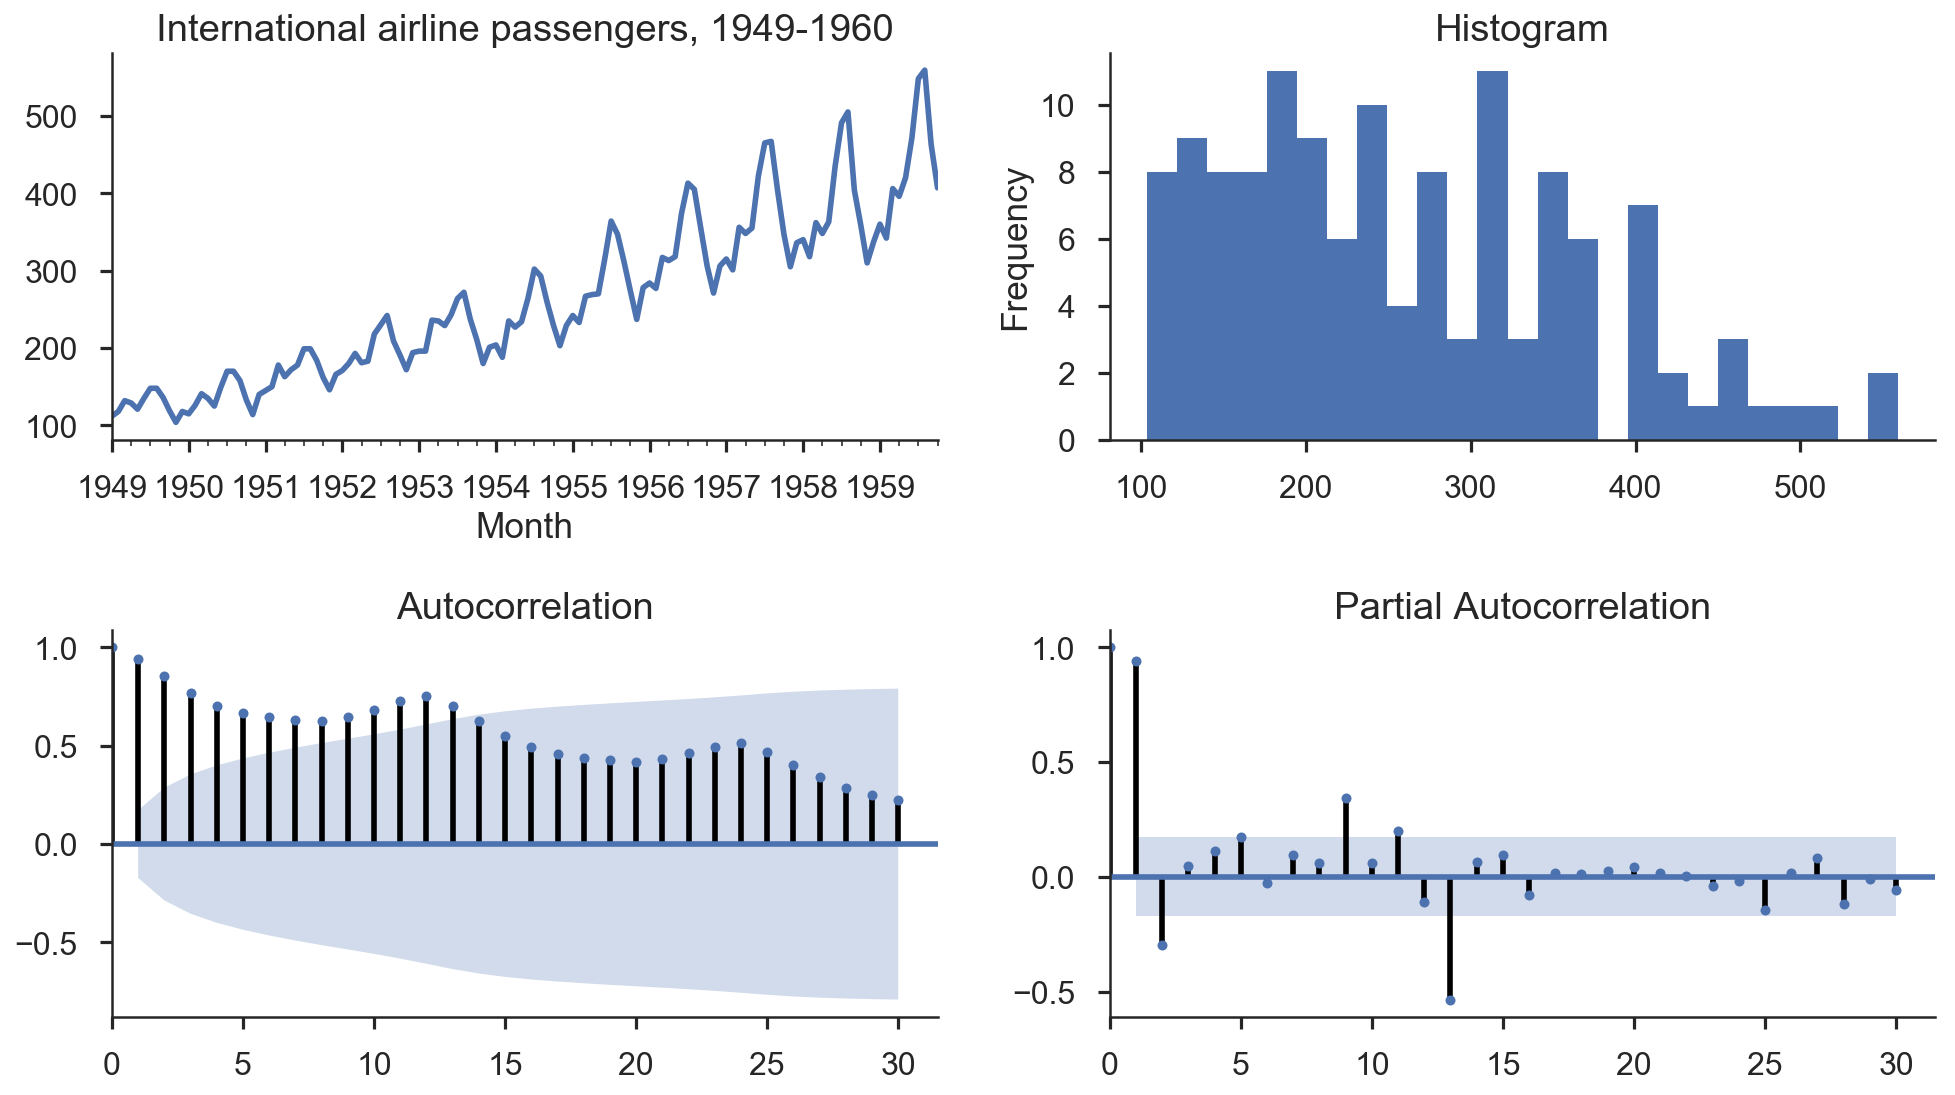

In [35]:
# Step 2b: Examine the series and use the visuals as clues for the choice of the orders of the ARIMA model
tsplot(air_train, title='International airline passengers, 1949-1960', lags=30);

Month
1949-01-01   4.71850
1949-02-01   4.77068
1949-03-01   4.88280
1949-04-01   4.85981
1949-05-01   4.79579
Name: lnair, dtype: float64 

(144,) 

Month
1949-02-01    0.05219
1949-03-01    0.11212
1949-04-01   -0.02299
1949-05-01   -0.06402
1949-06-01    0.10948
Name: lnair, dtype: float64 

(143,) 



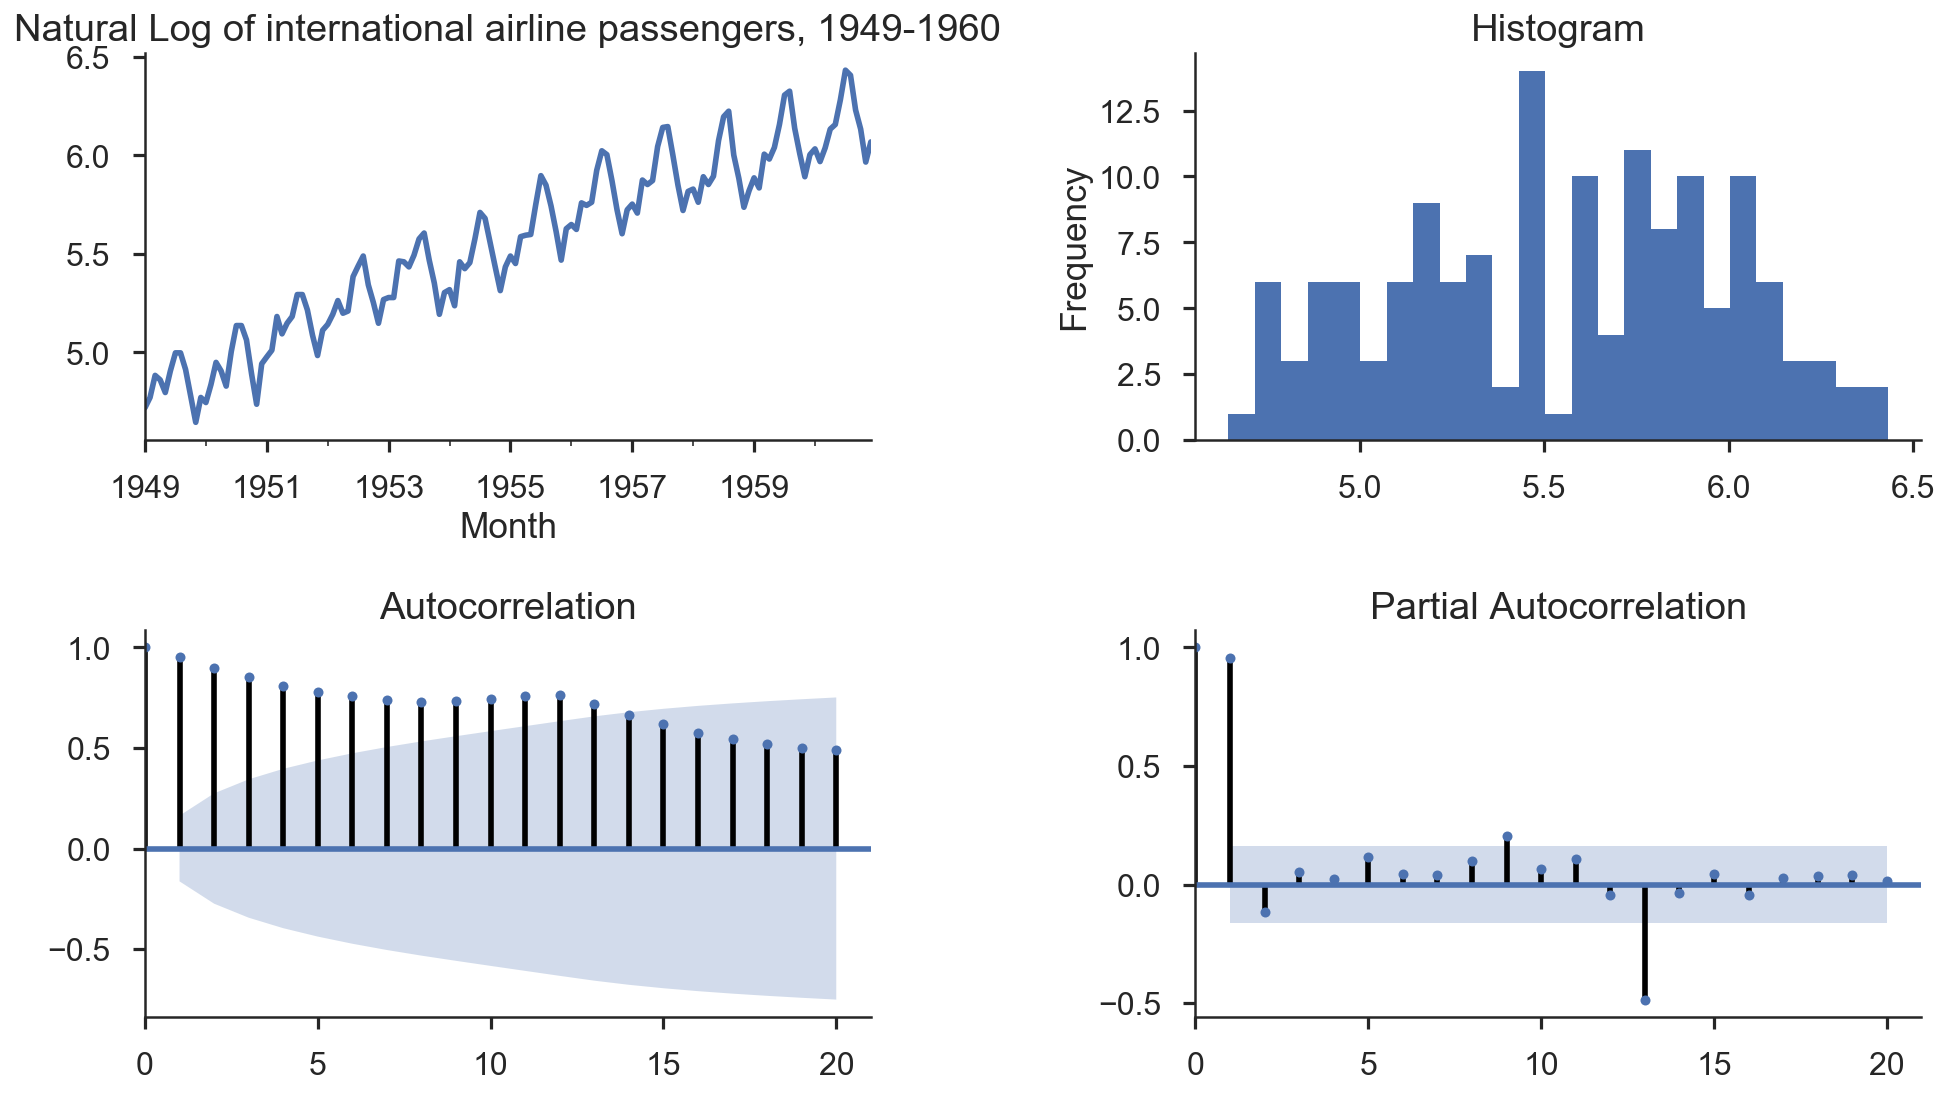

In [36]:
# Step 2c: Conduct any necessary transformations (such as natural log, difference, difference in natural log, etc )
# and repeat Step 2b
air['lnair'] = np.log(air)
print(air['lnair'].head(),"\n")
print(air['lnair'].shape,"\n")

# Take first difference of the series
#air_ln_diff = air['lnair'].diff() - air['lnair'].shift()
air_ln_diff = air['lnair'].diff()
air_ln_diff = air_ln_diff.dropna()
print(air_ln_diff.head(),"\n")
print(air_ln_diff.shape,"\n")
tsplot(air['lnair'], title='Natural Log of international airline passengers, 1949-1960', lags=20);

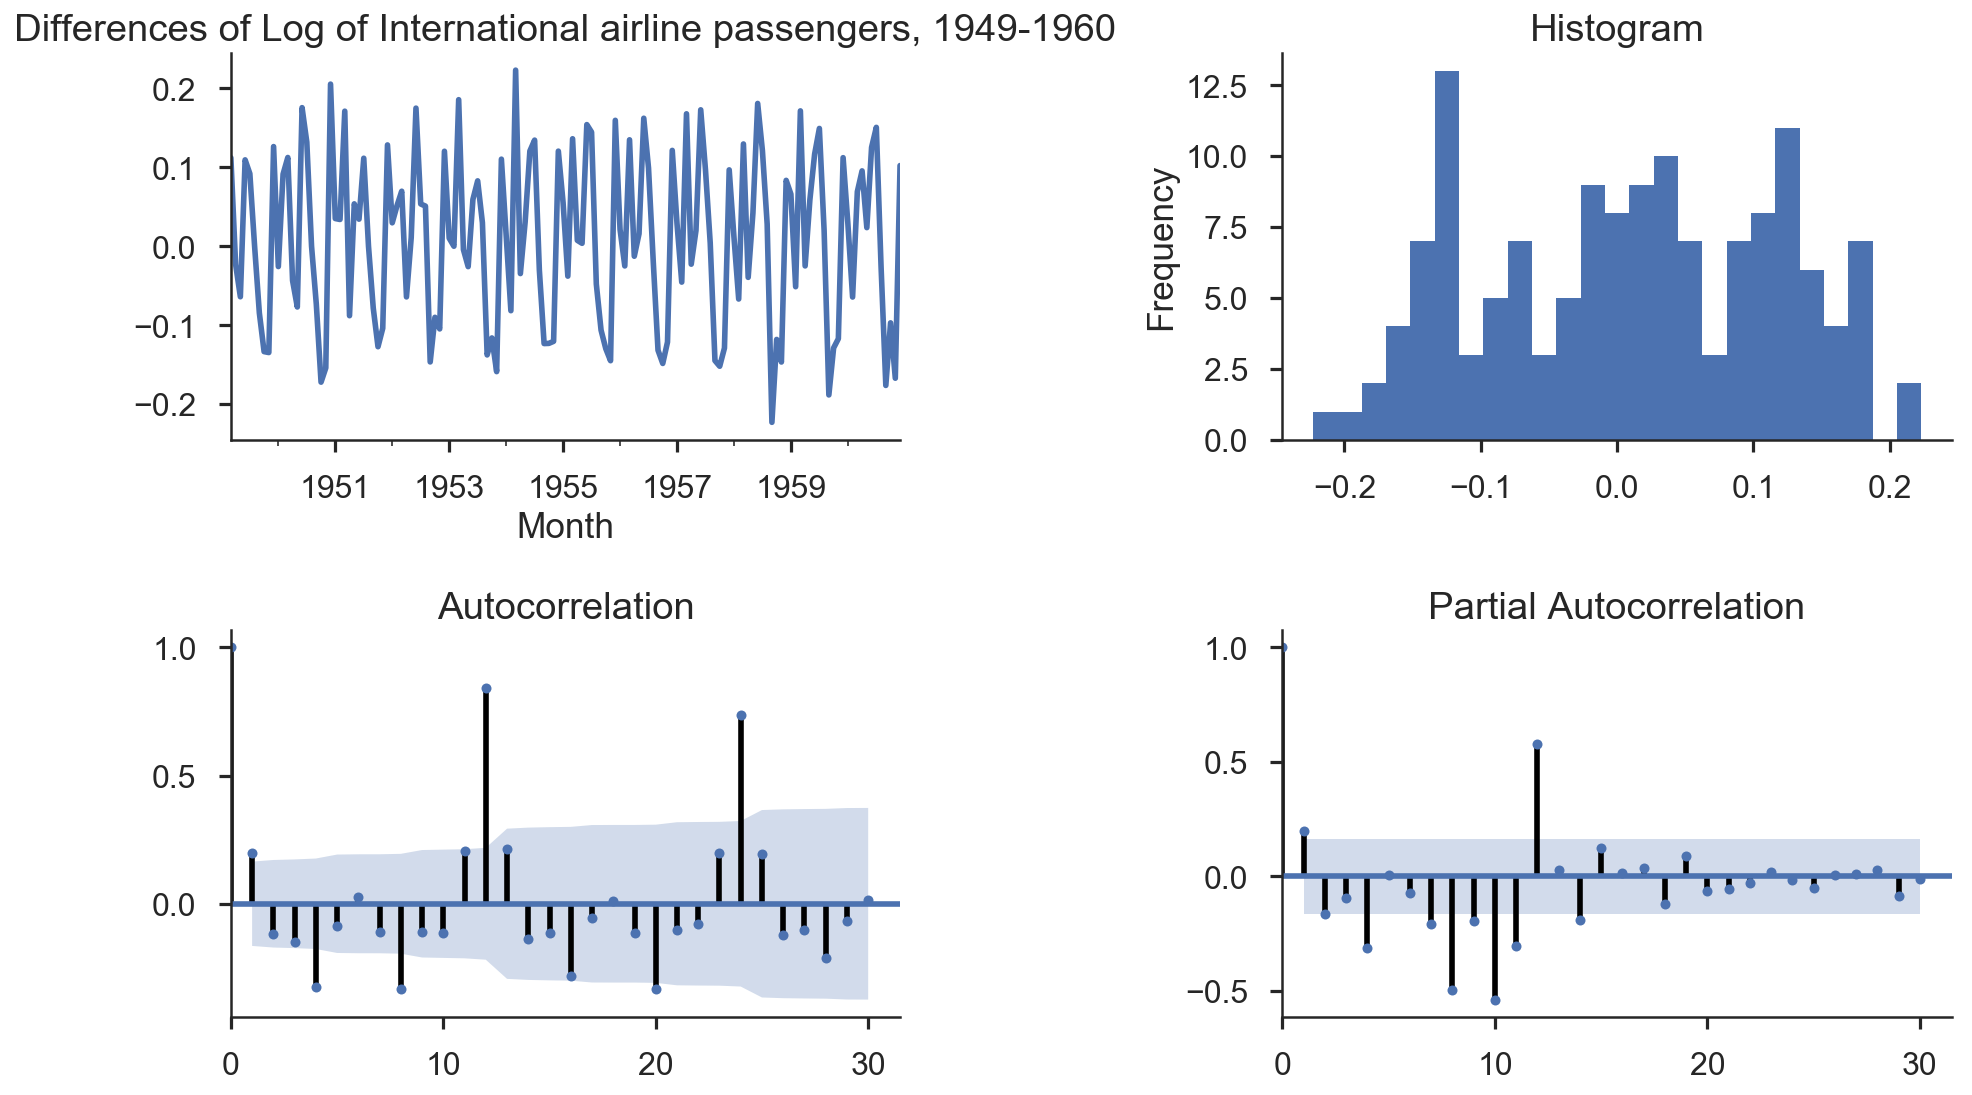

In [37]:
tsplot(air_ln_diff[1:], title='Differences of Log of International airline passengers, 1949-1960', lags=30);

### 4.2 model identification & estimation

In [38]:
# Step 3: Estimate an Seasonal ARIMA model
# Note: you will have to pick the orders (p,d,q)(P,D,Q)_s

#mod = sm.tsa.statespace.SARIMAX(liquor, order=(?,?,?), seasonal_order=(?,?,?,?))
mod = sm.tsa.statespace.SARIMAX(air_train, order=(1,1,0), seasonal_order=(0,0,0,12))
sarima_fit2 = mod.fit()
print(sarima_fit2.summary())

                           Statespace Model Results                           
Dep. Variable:       n_pass_thousands   No. Observations:                  130
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -620.502
Date:                Fri, 08 Sep 2017   AIC                           1245.003
Time:                        14:50:16   BIC                           1250.738
Sample:                    01-01-1949   HQIC                          1247.333
                         - 10-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2987      0.093      3.226      0.001       0.117       0.480
sigma2       881.4286     88.488      9.961      0.000     707.996    1054.861
Ljung-Box (Q):                      298.41   Jarque-

### 4.3 model diagnostics

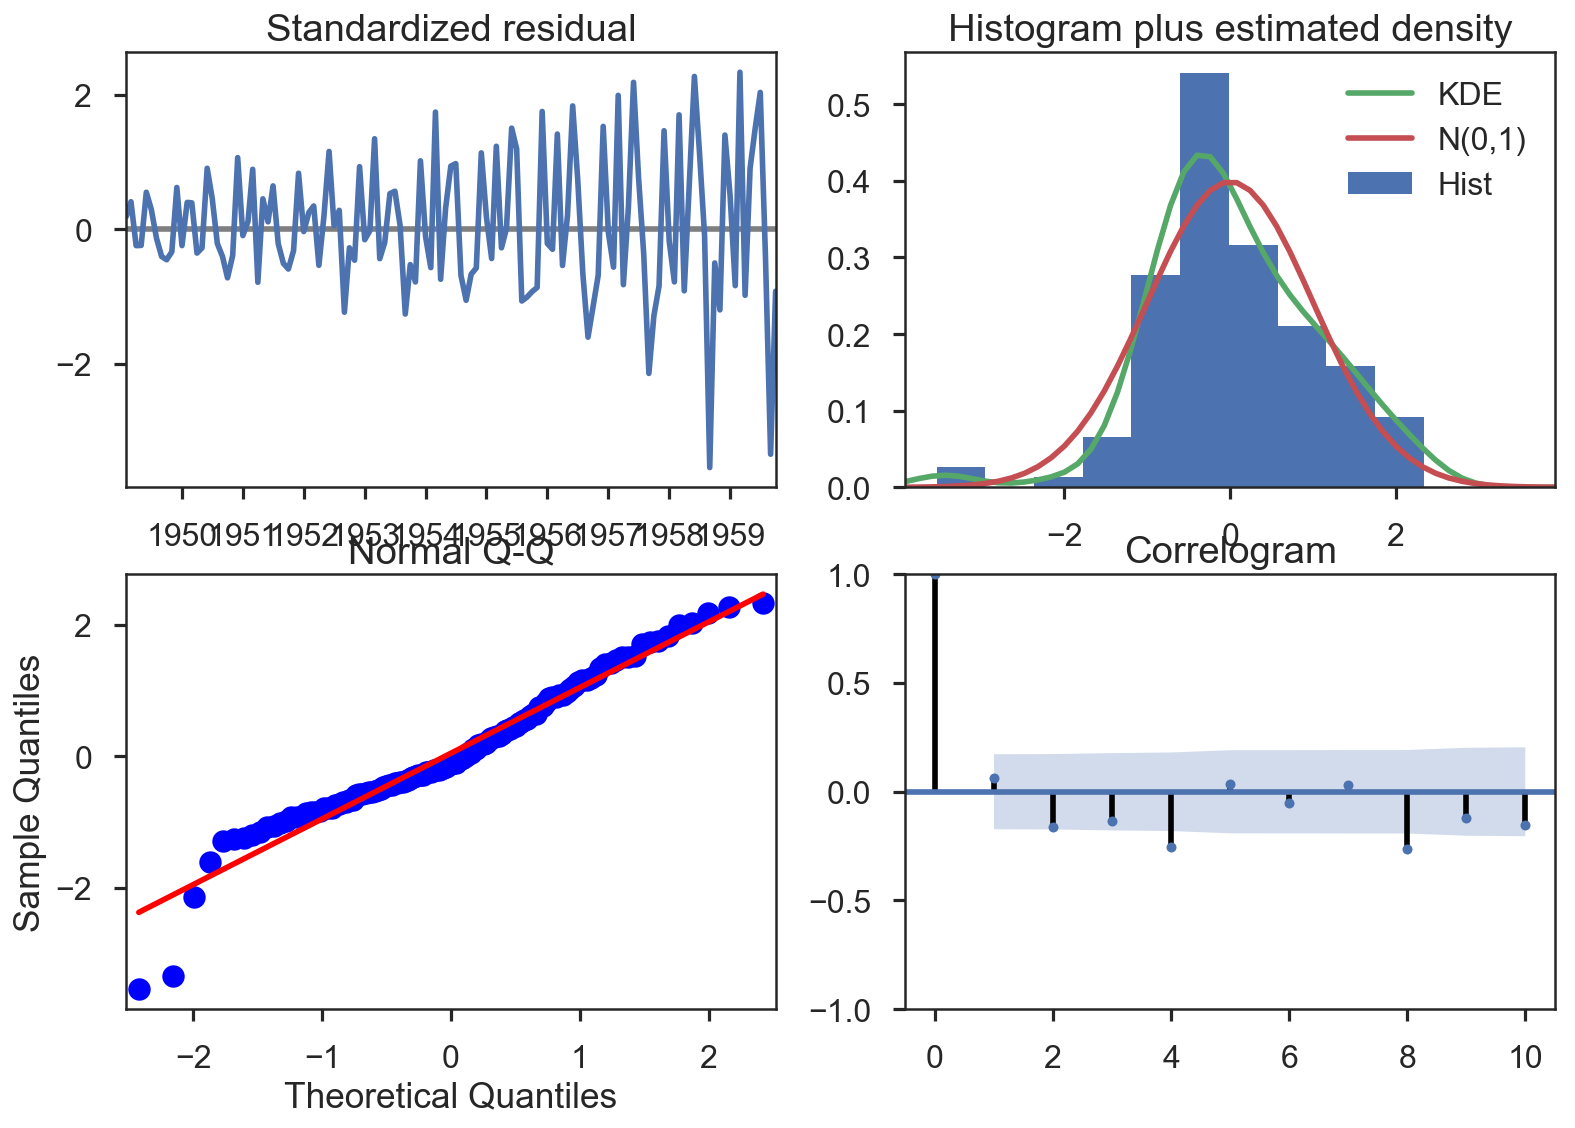

In [39]:
# Step 4: Conduct model diagnostic check
sarima_fit2.plot_diagnostics();

# Discuss these plots

### 4.4 forecasting and evaluation

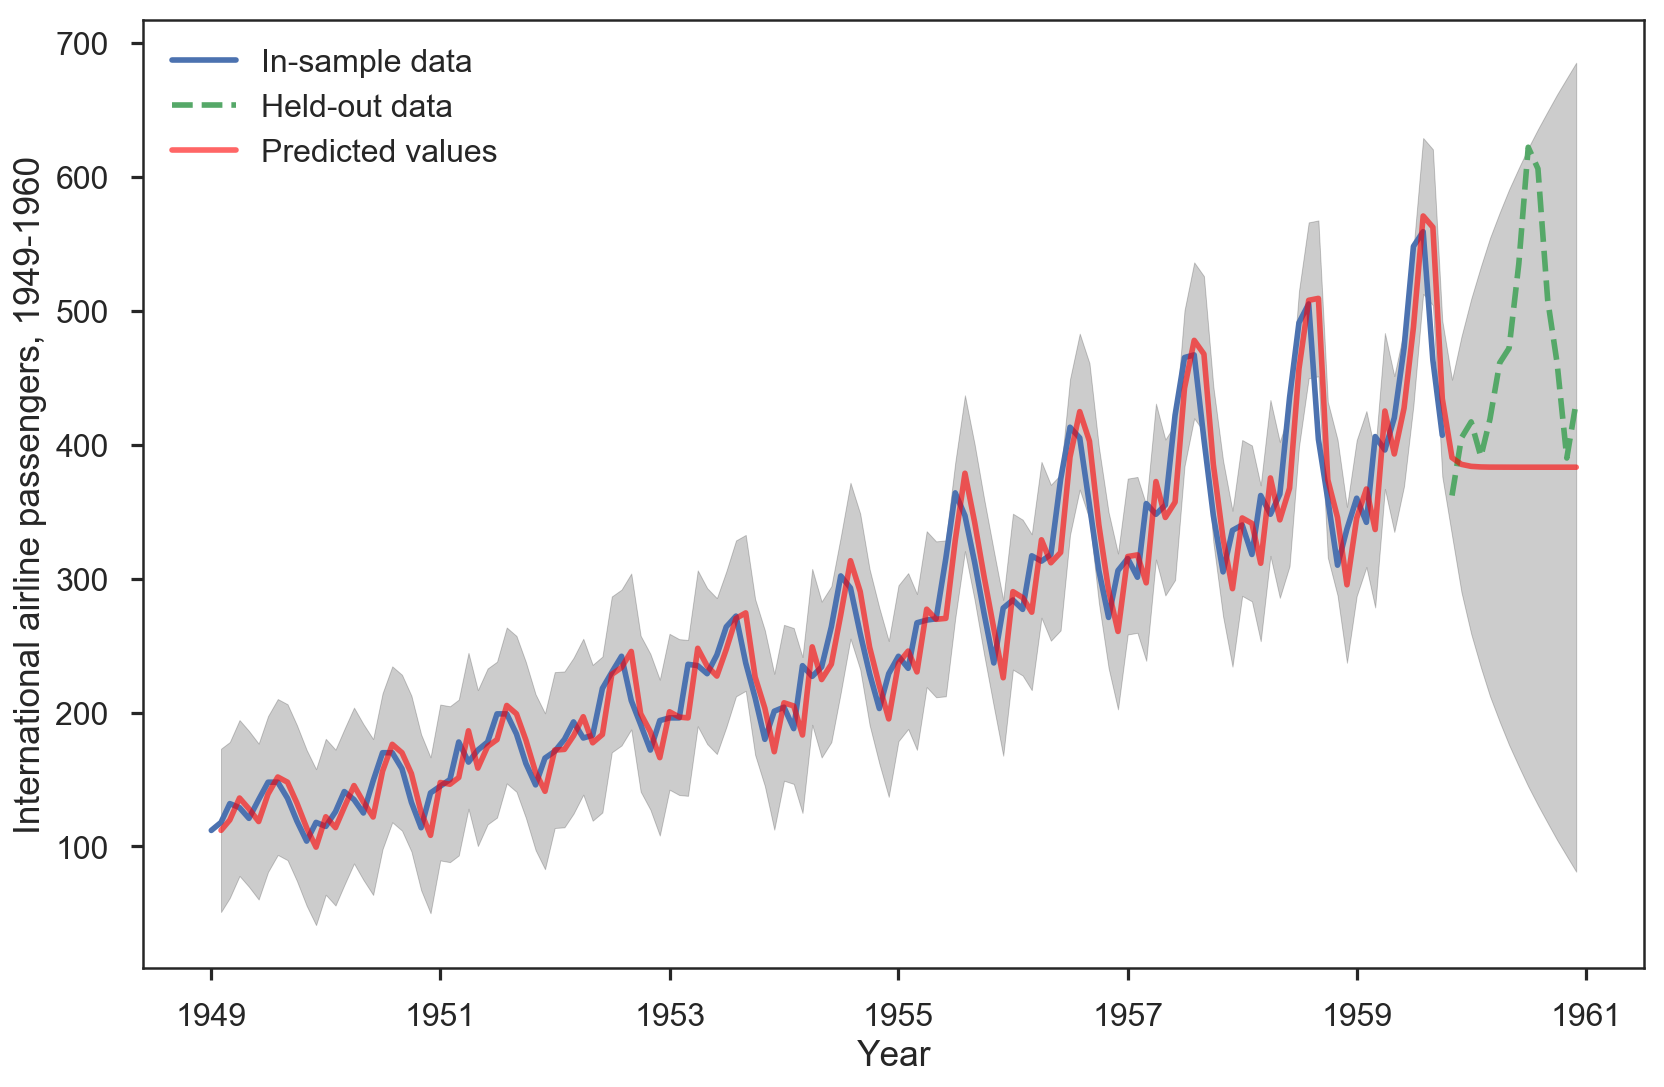

In [40]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(air_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(air_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = air_train.index[sarima_fit2.loglikelihood_burn]
pred_end = air_test.index[-1]
pred = sarima_fit2.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("International airline passengers, 1949-1960")
ax1.legend(loc='best');
fig.tight_layout();
## Discuss the results.  How does your forecast look?

In [41]:
rmse_train = get_rmse(air_train, pred_mean[air_train.index])
rmse_test = get_rmse(air_test, pred_mean[air_test.index])
print("RMSE of training data is", rmse_train)
print("RMSE of testing data is", rmse_test)

RMSE of training data is 29.6897772644
RMSE of testing data is 110.662385766


# It is your turn!

(216,)
(23,)
Training Series: 
 Time
2014-04-01    744.08504
2014-05-01   1234.46802
2014-06-01    997.64834
2014-07-01    815.13931
2014-08-01   1012.11754
Name: Box_sum, dtype: float64 

Testing Series: 
 Time
2014-09-01    455.19932
2014-10-01    886.46799
2014-11-01   1138.29679
2014-12-01   1322.24424
2015-01-01    406.00914
Name: Box_sum, dtype: float64


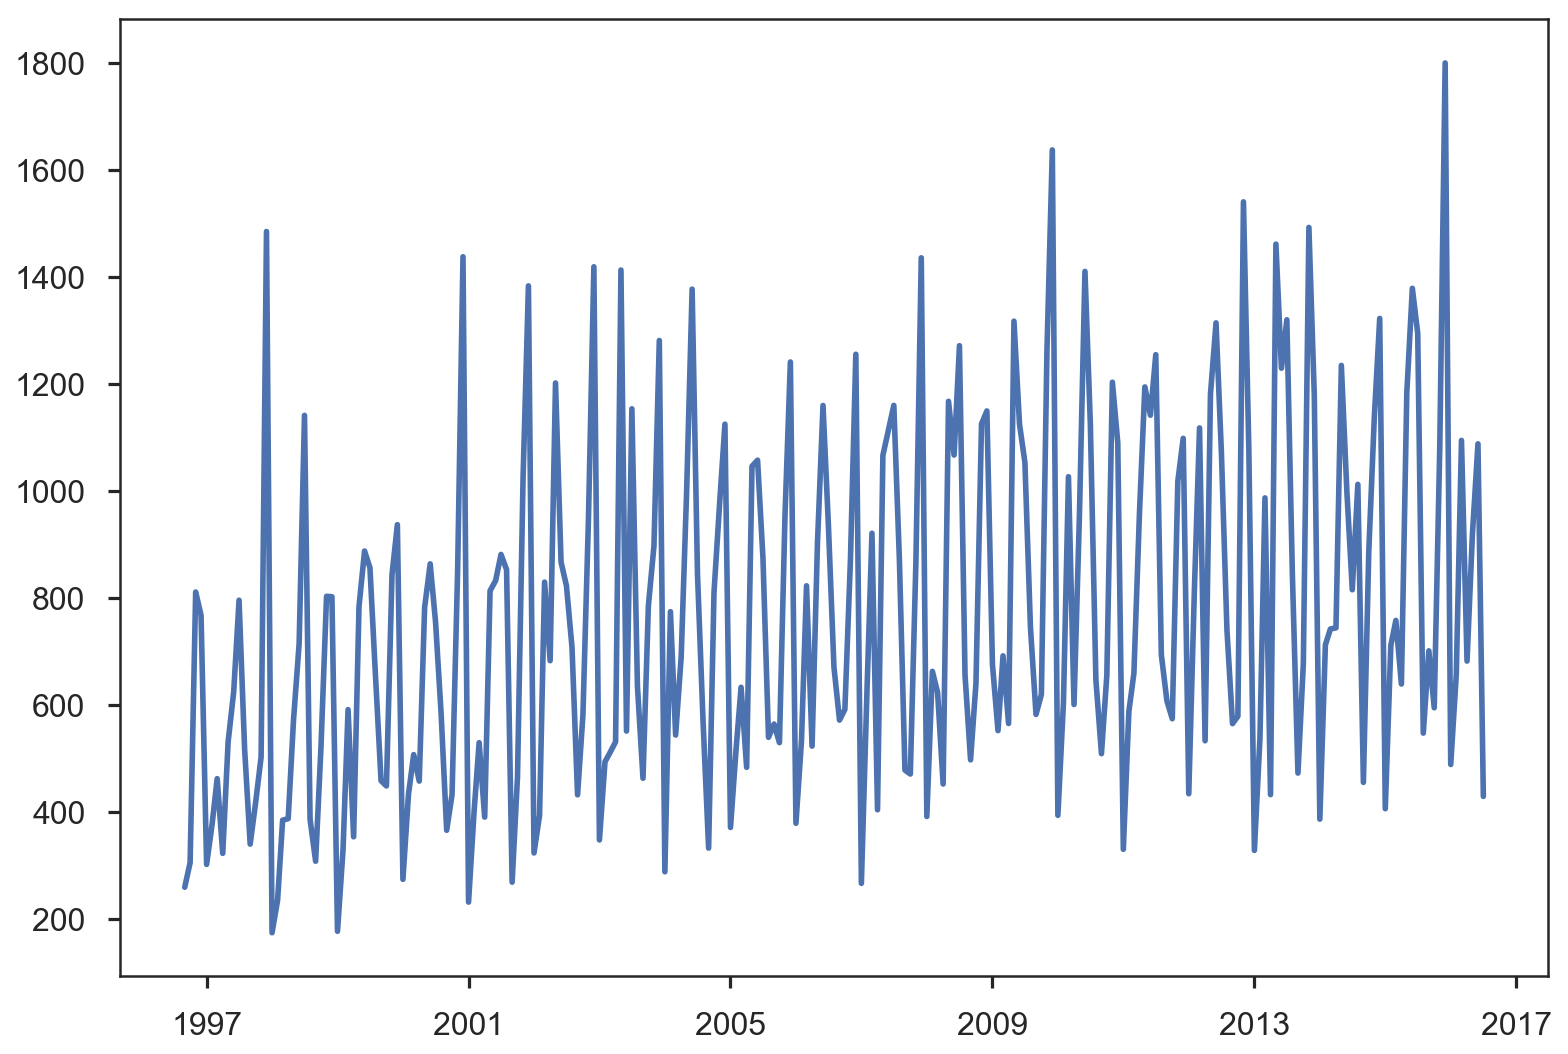

In [42]:
# Step 1: Import the data series
movie = pd.read_csv('data/moviedata.csv', header=0, index_col=0, parse_dates=[0])
movie = movie.iloc[200:]
plt.plot(movie)
# Step 1b: Create the training and testing series before analyzing the series
n_sample = movie.shape[0]
n_train=int(0.90*n_sample)+1
n_forecast=n_sample-n_train

movie_train = movie.iloc[:n_train]['Box_sum']
movie_test  = movie.iloc[n_train:]['Box_sum']
print(movie_train.shape)
print(movie_test.shape)
print("Training Series:", "\n", movie_train.tail(), "\n")
print("Testing Series:", "\n", movie_test.head())

In [43]:
# Step 2a: Examine the basic structure of the data
print("Data shape:", movie_train.shape, "\n")
print("First 5 observations of the training data series:", "\n", movie_train.head(), "\n")
print("Last 5 observations of the training data series:", "\n", movie_train.tail())

Data shape: (216,) 

First 5 observations of the training data series: 
 Time
1996-09-01   259.25613
1996-10-01   305.09300
1996-11-01   811.01154
1996-12-01   767.50882
1997-01-01   301.91058
Name: Box_sum, dtype: float64 

Last 5 observations of the training data series: 
 Time
2014-04-01    744.08504
2014-05-01   1234.46802
2014-06-01    997.64834
2014-07-01    815.13931
2014-08-01   1012.11754
Name: Box_sum, dtype: float64


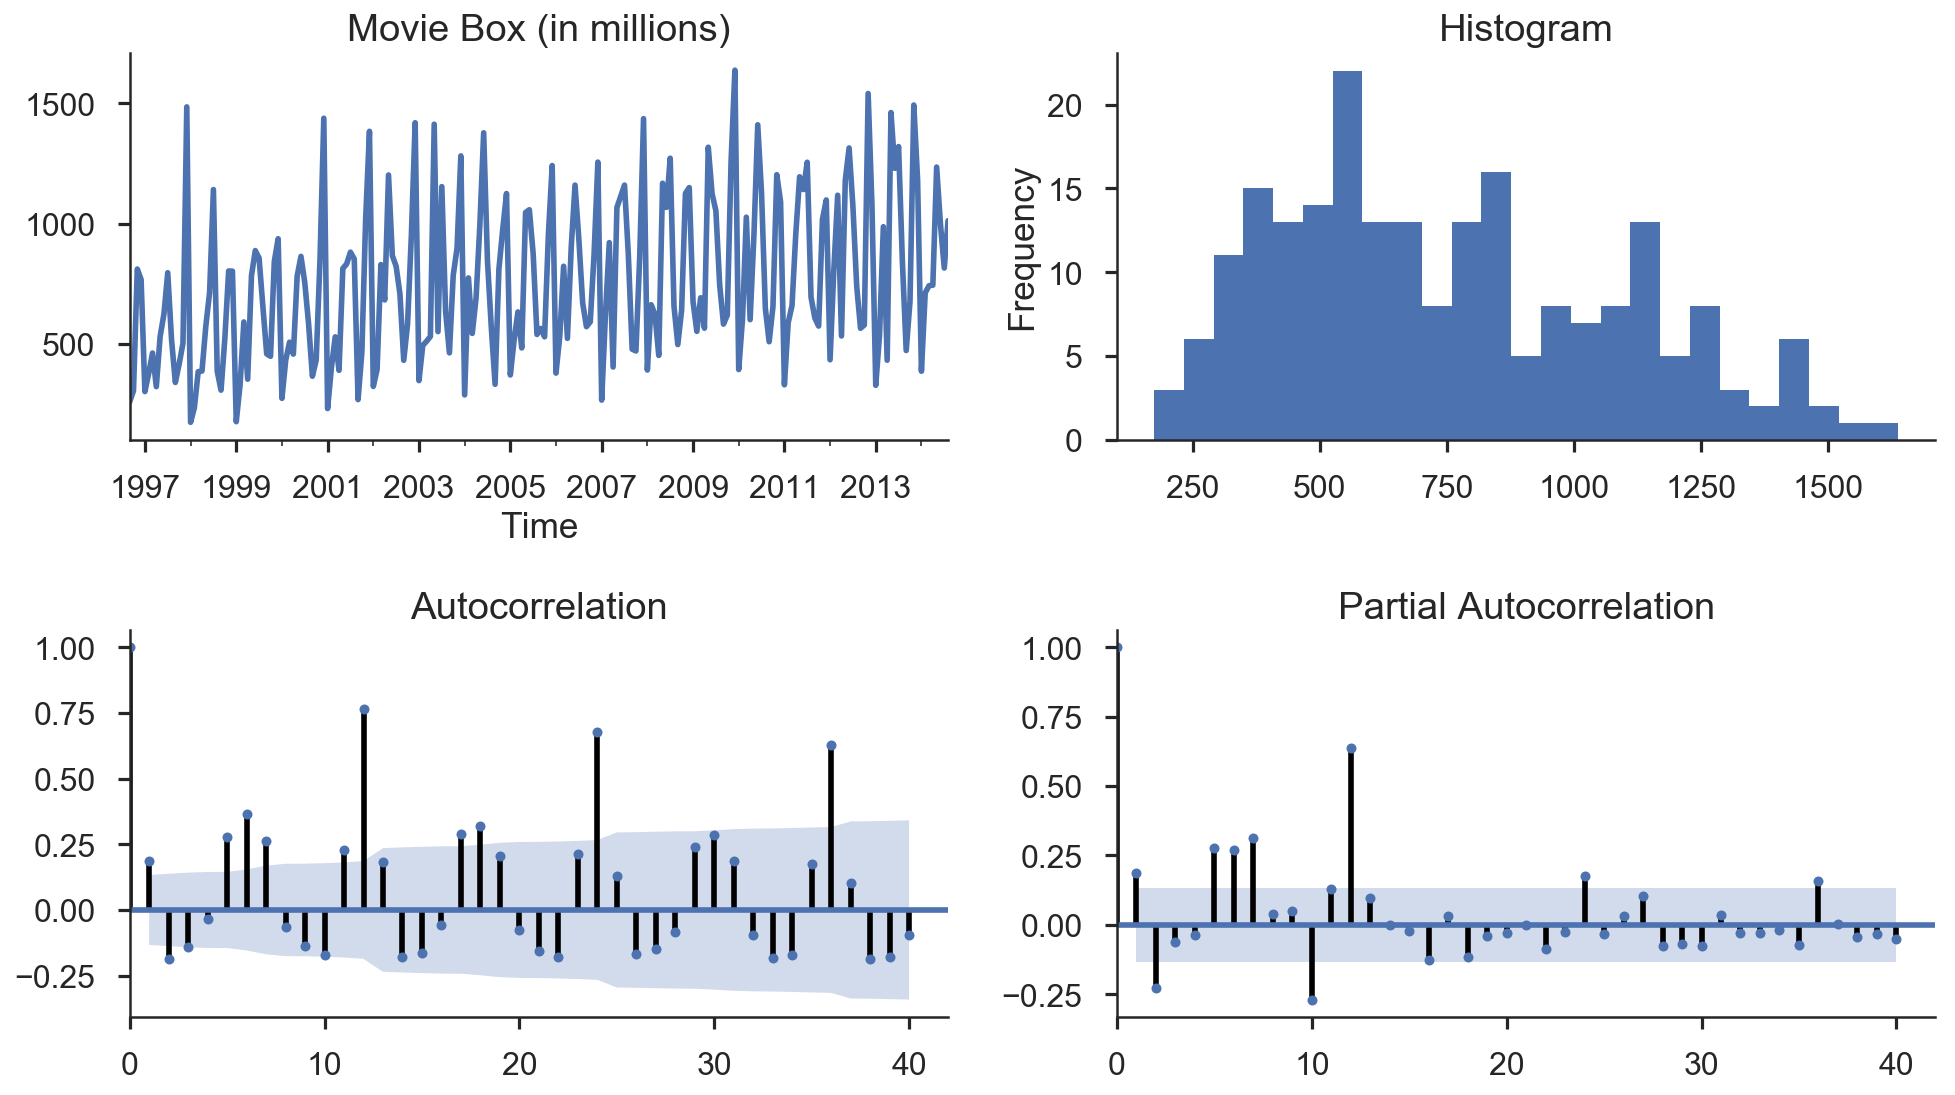

In [44]:
# Step 2b: Examine the series and use the visuals as clues for the choice of the orders of the ARIMA model
tsplot(movie_train, title='Movie Box (in millions)', lags=40);

In [45]:
# # Step 2c: Conduct any necessary transformations (such as natural log, difference, difference in natural log, etc )
# # and repeat Step 2b
# # Take log of the series
# movie['lnmovie'] = np.log(movie)
# print(movie['lnmovie'].head(),"\n")
# print(movie['lnmovie'].shape,"\n")

# # Take first difference of the series
# movie_ln_diff = movie['lnmovie'].diff()
# movie_ln_diff = movie_ln_diff.dropna()
# print(movie_ln_diff.head(),"\n")
# print(movie_ln_diff.shape,"\n")
# tsplot(movie['lnmovie'], title='Natural Log of Movie Box in the USA', lags=20);


In [46]:
# Step 3: Estimate an Seasonal ARIMA model
# Note: you will have to pick the orders (p,d,q)(P,D,Q)_s

#mod = sm.tsa.statespace.SARIMAX(movie, order=(?,?,?), seasonal_order=(?,?,?,?))

mod = sm.tsa.statespace.SARIMAX(movie_train, order=(1,0,0), seasonal_order=(0,0,0,12))
sarima_fit2 = mod.fit()
print(sarima_fit2.summary())

                           Statespace Model Results                           
Dep. Variable:                Box_sum   No. Observations:                  216
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1605.116
Date:                Fri, 08 Sep 2017   AIC                           3214.232
Time:                        14:50:21   BIC                           3220.982
Sample:                    09-01-1996   HQIC                          3216.959
                         - 08-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8688      0.030     28.546      0.000       0.809       0.928
sigma2      1.664e+05   1.61e+04     10.361      0.000    1.35e+05    1.98e+05
Ljung-Box (Q):                      497.01   Jarque-

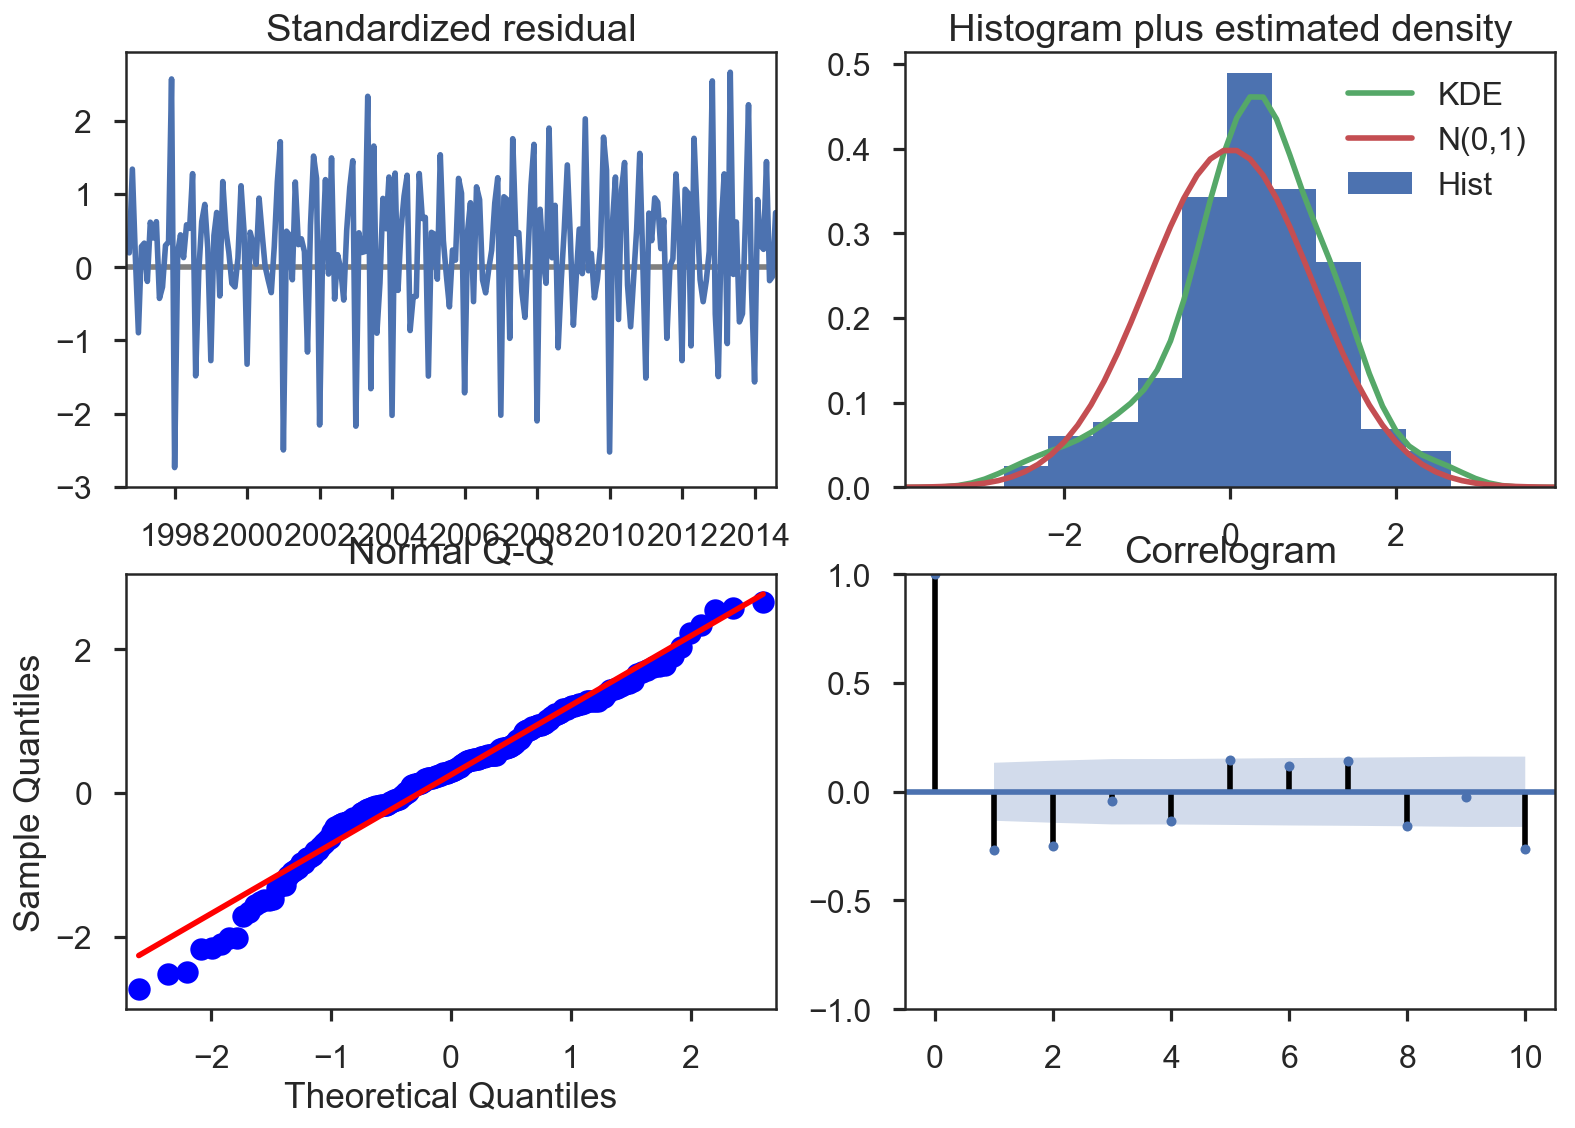

In [47]:
# Step 4: Conduct model diagnostic check
sarima_fit2.plot_diagnostics();

# Discuss these plots

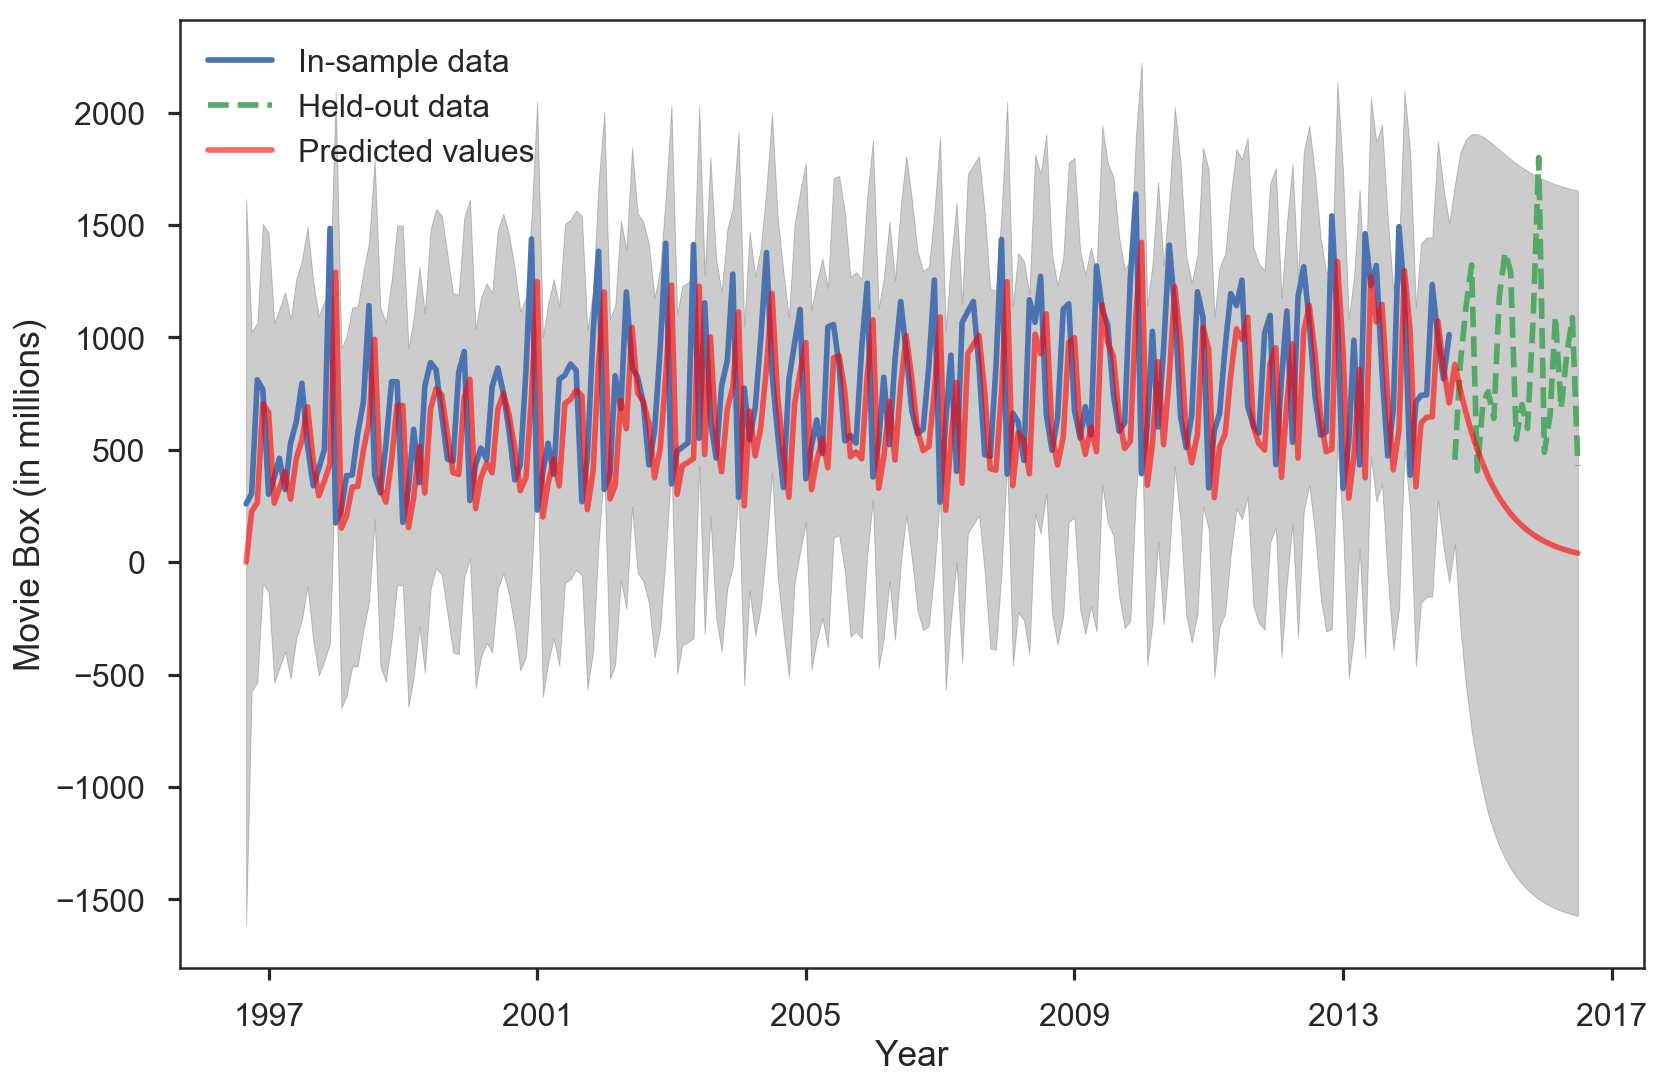

In [48]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(movie_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(movie_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = movie_train.index[sarima_fit2.loglikelihood_burn]
pred_end = movie_test.index[-1]
pred = sarima_fit2.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("Movie Box (in millions)")
ax1.legend(loc='best');
fig.tight_layout();
## Discuss the results.  How does your forecast look?

In [49]:
rmse_train = get_rmse(movie_train, pred_mean[movie_train.index])
rmse_test = get_rmse(movie_test, pred_mean[movie_test.index])
print("RMSE of training data is", rmse_train)
print("RMSE of testing data is", rmse_test)
print("Note: the sample size of training and testing data are different. You can't compare these two values directly")

RMSE of training data is 407.322028073
RMSE of testing data is 748.144902112
Note: the sample size of training and testing data are different. You can't compare these two values directly


# Reference

### 1. Textbook
#### Analysis of Financial Time Series, Second Edition by Ruey S. Tsay, Wiley, 2005. ISBN: 0-471-69074-0
#### http://www.lcs.poli.usp.br/~ablima/livros/Analysis%20of%20financial%20time%20series%20Tsay.pdf
#### http://faculty.chicagobooth.edu/ruey.tsay/teaching/

### 2. Online Video and Tutorial
#### Jeffrey Yau | Applied Time Series Econometrics in Python and R
#### Video: https://www.youtube.com/watch?v=tJ-O3hk1vRw
#### Github: https://github.com/silicon-valley-data-science/pydata-sf-2016-arima-tutorial

#### Aileen Nielsen - Time Series Analysis - PyCon 2017
#### Video: https://www.youtube.com/watch?v=zmfe2RaX-14&t=9625s
#### Github: https://github.com/AileenNielsenPyCon/TimeSeries

### 3. Package
#### Statsmodels’s Documentation
#### http://www.statsmodels.org/dev/index.html